

<br>
<br>


<h1><center> SFS </center></h1>


<br>
<br>


#### Signal Formation Simulation
The idea is to develop a lightweight and easy-to-use tool for the top-down how affects the performance of the next-generation dark matter detector.
The code is based on the Noble Element Simulation Technique (NEST).


<br>
<br>


#### This Notebook
This is the notebook that was used to actually conduct the study.
It is supposed to further serve as documentation of the ''sfs.py'' library. Feel free to copy the exemplary function calls below into your personal study project.


<br>
<br>


#### Contents


1. **[Setup](#Setup)**
2. **[Imports and Definitions](#Imports-and-Definitions)**
3. **[Detector Definition](#Detector-Definition)**
4. **[Spectra Definition](#Spectra-Definition)**
5. **[Executing NEST](#Executing-NEST)**
6. **[ER/NR Discrimination](#ER/NR-Discrimination)**
7. **[Maximum Likelihood Sensitivity Estimation](#Maximum-Likelihood-Sensitivity-Estimation)**


<br>
<br>


#### Credits
- NEST collaboration
- C. Hock


<br>
<br>



<br>
<br>


# Setup


<br>
<br>


- install NEST following their official documentation


- Store the absolute path of the NEST installation, i.e., the directory containing the `nest`, `install`, and `build` directories, in an environmental variable. Therefore execute:<br> `$ echo 'export ABSPATH_NEST_INSTALLATION="/abspath/to/your/nest/root/directory/" >> ~/.bashrc'`


- git clone the ''sfsv2'' repository


- edit the ''sfs.py'' file


<br>
<br>



<br>
<br>


# Imports and Definitions


<br>
<br>


#### paths

In [1]:


# path definitions
abspath_sfs_repo = "/home/daniel/Desktop/arbeitsstuff/sfs/github_repo_v2/"
abspath_study = abspath_sfs_repo # you'll probably have different paths for 'abspath_sfs_repo' and 'abspath_study'
abspath_detectors = abspath_study +"detectors/"
abspath_spectra = abspath_study +"spectra/"
abspath_resources = abspath_study +"resources/"
abspath_list_plots = [abspath_study +"plots/", "/home/daniel/Desktop/arbeitsstuff/thesis/images/sfs/"]
abspath_signatures = abspath_study +"signatures/"
abspath_discrimination_lines = abspath_study +"discrimination_lines/"



#### imports

In [2]:

# imports <---- check which one of those are actually needed
import subprocess
import numpy as np
import matplotlib.pyplot as plt
from random import randrange
import time
from datetime import timedelta


# importing my personal matplotlib style file
import matplotlib as mpl
plt.style.use("file:///home/daniel/Desktop/arbeitsstuff/monxe/software/miscfig/danielsmplstyle.mplstyle")


# importing the sfs library
import sys
sys.path.append(abspath_sfs_repo)
import sfs


#### study assumptions

In [3]:


# default study parameters
default_wimp_eroi_kev_ee = [1.4, 10.6] # WIMP energy region of interest in keV_ee
default_wimp_eroi_kev_nr = [4.9, 40.9] # WIMP energy region of interest in keV_nr
default_wimp_mass_gev = 50 # WIMP mass in GeV
default_wimp_nucleon_cross_section_cm2 = 1e-47 # WIMP-nucleon cross-section in cm^2


# default study settings
default_simulation_energy_bins = 50 # number of energy bins used for the spectra simulation
default_recoil_energy_simulation_window_er = [0.25, default_wimp_eroi_kev_ee[1]*1.5] # energy simulation window for ER signatures (due to leakage one needs to simulate events from outside the EROI)
default_recoil_energy_simulation_window_nr = [3.5, default_wimp_eroi_kev_nr[1]*1.5] # energy simulation window for ER signatures (due to leakage one needs to simulate events from outside the EROI)
default_number_of_discrimination_line_energy_bins = 10 # number of energy bins into which the WIMP EROI is subdivided for the computation of the ER rejection
default_nr_acceptance = 0.30 # acceptance of the (not in percent) of the nuclear recoils on which the NR computation is based




<br>
<br>


# DARWIN Baseline Detector Definition


<br>
<br>


In [4]:


# defining the 'detector_dict'
darwin_baseline_detector_dict = {
    # primary scintillation (S1) parameters
    "g1"                : 0.12,                     # phd per S1 phot at dtCntr (not phe), divide out 2-PE effect,                          JN: 0.119, LUX_Run03: 0.1170 (0.117+/-0.003 WS,0.115+/-0.005 D-D,0.115+/-0.005 CH3T,0.119+/-0.001 LUXSim), XENON10: 0.073
    "sPEres"            : 0.37,                     # single phe (=PE=photoelectrons) resolution (Gaussian assumed),                        JN: 0.38, LUX_Run03: 0.37 (arXiv:1910.04211.), XENON10: 0.58
    "sPEthr"            : 0.35,                     # POD threshold in phe, usually used IN PLACE of sPEeff,                                JN: 0.35, LUX_Run03: (0.3 * 1.173) / 0.915 (arXiv:1910.04211.), XENON10: 0.35
    "sPEeff"            : 0.9,                      # actual efficiency, can be used in lieu of POD threshold, units: fractional,           JN: 0.90, LUX_Run03: 1.00 (arXiv:1910.04211), XENON10: 1.00
    "noiseBaseline[0]"  : 0.0,                      # baseline noise mean in PE (Gaussian),                                                 JN: 0.0, LUX_Run03: 0.00 (arXiv:1910.04211 says -0.01), XENON10: 0.0
    "noiseBaseline[1]"  : 0.0,                      # baseline noise width in PE (Gaussian),                                                JN: 0.0, LUX_Run03: 0.08 (arXiv:1910.04211), XENON10: 0.0
    "noiseBaseline[2]"  : 0.0,                      # baseline noise mean in e- (for grid wires),                                           JN: none, LUX_Run03: 0.0, XENON10: 0.0
    "noiseBaseline[3]"  : 0.0,                      # baseline noise width in e- (for grid wires),                                          JN: none, LUX_Run03: 0.0, XENON10: 0.0
    "P_dphe"            : 0.2,                      # chance 1 photon makes 2 phe instead of 1 in Hamamatsu PMT, units: fractional,         JN: 0.22, LUX_Run03: 0.173 (arXiv:1910.04211), XENON10: 0.2
    "coinWind"          : 100,                      # S1 coincidence window in ns,                                                          JN: 100, LUX_Run03: 100 (1310.8214), XENON10: 100
    "coinLevel"         : 3,                        # how many PMTs have to fire for an S1 to count,                                        JN: 3, LUX_Run03: 2 (1512.03506), XENON10: 2
    "numPMTs"           : 494,                      # for coincidence calculation,                                                          JN: 494, LUX_Run03: 119 (122 minus 3 off), XENON10: 89
    "OldW13eV"          : "true",                   # default true, which means use "classic" W instead of Baudis / EXO's,                  JN: none, LUX_Run03: "true", XENON10: "true"
    "noiseLinear[0]"    : 0.0e-2,                   # S1->S1 Gaussian-smeared with noiseL[0]*S1, units: fraction NOT %!                     JN: none, LUX_Run03: 0.0e-2 (1910.04211 p.12, to match 1610.02076 Fig. 8.), XENON10: 3e-2
    "noiseLinear[1]"    : 0.0e-2,                   # S2->S2 Gaussian-smeared with noiseL[1]*S2, units: fraction NOT %!                     JN: none, LUX_Run03: 0.0e-2 (1910.04211 p.12, to match 1610.02076 Fig. 8.), XENON10: 3e-2
    # ionization and secondary scintillation (S2) parameters
    "g1_gas"            : 0.1,                      # phd per S2 photon in gas, used to get SE size, units: phd per e-,                     JN: 0.102, LUX_Run03: 0.1 (0.1 in 1910.04211), XENON10: 0.0655
    "s2Fano"            : 3.6,                      # Fano-like fudge factor for SE width, dimensionless,                                   JN: 3.61, LUX_Run03: 3.6 (3.7 in 1910.04211; this matches 1608.05381 better), XENON10: 3.61
    "s2_thr"            : -100,                      # the S2 threshold in phe or PE, *not* phd. Affects NR most,                            JN: 100.0, LUX_Run03: (150.0 * 1.173) / 0.915 (65-194 pe in 1608.05381), XENON10: 300.0
    "E_gas"             : 10.0,                     # field in kV/cm between liquid/gas border and anode,                                   JN: 10.85, LUX_Run03: 6.25 (6.55 in 1910.04211), XENON10: 12.0
    "eLife_us"          : 5000.0,                   # the drift electron mean lifetime in micro-seconds,                                    JN: 1600.0, LUX_Run03: 800.0 (p.44 of James Verbus PhD thesis Brown), XENON10: 2200.0
    # thermodynamic properties
#    "inGas"             : "false",                  # (duh),                                                                               JN: "false", LUX_Run03: commented out, XENON10: "false"
    "T_Kelvin"          : 175.0,                    # for liquid drift speed calculation, temperature in Kelvin,                            JN: 175.0, LUX_Run03: 173.0 (1910.04211), XENON10: 177.0
    "p_bar"             : 2.0,                      # gas pressure in units of bars, it controls S2 size,                                   JN: 2.0, LUX_Run03: 1.57 (1910.04211), XENON10: 2.14
    # data analysis parameters and geometry
    "dtCntr"            : 900.0,                    # center of detector for S1 corrections, in usec.,                                      JN: 822.0, LUX_Run03: 160.0 (p.61 Dobi thesis UMD, 159 in 1708.02566), XENON10: 40.0
    "dt_min"            : 100.0,                    # minimum. Top of detector fiducial volume, units: microseconds,                        JN: 75.8, LUX_Run03: 38.0 (1608.05381), XENON10: 20.0
    "dt_max"            : 1700.0,                   # maximum. Bottom of detector fiducial volume, units: microseconds,                     JN: 1536.5, LUX_Run03: 305.0 (1608.05381), XENON10: 60.0
    "radius"            : 1250.0,                   # millimeters (fiducial rad), units: millimeters,                                       JN: 1300., LUX_Run03: 200.0 (1512.03506), XENON10: 50.0
    "radmax"            : 1300.0,                   # actual physical geo. limit, units: millimeters,                                       JN: 1350., LUX_Run03: 235.0 (1910.04211), XENON10: 50.0
    "TopDrift"          : 2650.0,                   # top of drift volume in mm not cm or us, i.e., this *is* where dt=0, z=0mm is cathode,  JN: 3005.0, LUX_Run03: 544.95 (544.95 in 1910.04211), XENON10: 150.0
    "anode"             : 2655.0,                   # the level of the anode grid-wire plane in mm,                                         JN: 3012.5, LUX_Run03: 549.2 (1910.04211 and 549 in 1708.02566), XENON10: 152.5
    "gate"              : 2645.0,                   # mm. this is where the E-field changes (higher),                                       JN: 3000.0, LUX_Run03: 539.2 (1910.04211 and 539 in 1708.02566), XENON10: 147.5
    "cathode"           : 50.0,                     # mm. defines point below which events are gamma-X                                      JN: 250, LUX_Run03: 55.90 (55.9-56 in 1910.04211,1708.02566), XENON10: 1.00
    # 2D (xy) position reconstruction
    "PosResExp"         : 0.015,                    # exp increase in pos recon res at hi r, units: 1/mm,                                   JN: 0.015, LUX_Run03: 0.015 (arXiv:1710.02752 indirectly), XENON10: 0.015
    "PosResBase"        : 30.,                      # baseline unc in mm, see NEST.cpp for usage,                                           JN: 30.0, LUX_Run03: 70.8364 ((1710.02752 indirectly), XEONON10: 70.8364
}



# non-NEST detector parameters
darwin_baseline_detector_drift_field_v_cm = 200 # drift field of the darwin baseline design in V/cm
darwin_baseline_detector_runtime_y = 5 # live time of the experiment in years
darwin_baseline_detector_fiducial_mass_t = 30 # fiducial volume of the detector in metric tonnes


# adjusting drift times according to detector dimension
darwin_baseline_detector_dict = sfs.adjust_detector_drift_time_parameters(darwin_baseline_detector_dict, darwin_baseline_detector_drift_field_v_cm)


# saving the 'detector_dict' of the darwin baseline detector
sfs.write_dict_to_json(abspath_detectors +"example__detector__darwin_baseline_detector.json", darwin_baseline_detector_dict)


# derived parameters
darwin_baseline_detector_g2 = sfs.compute_g2_from_detector_configuration(darwin_baseline_detector_dict)
print(f"g2: {darwin_baseline_detector_g2} phd per primary electron")
darwin_baseline_detector_drift_velocity_mm_usec = sfs.compute_drift_velocity_from_detector_configuration(darwin_baseline_detector_dict,darwin_baseline_detector_drift_field_v_cm)
print(f"drift velocity: {darwin_baseline_detector_drift_velocity_mm_usec} mm/usec")
darwin_baseline_detector_active_xenon_mass_t = sfs.calc_active_xenon_mass_of_detector_dict_t(darwin_baseline_detector_dict)
print(f"active xenon mass: {darwin_baseline_detector_active_xenon_mass_t} tonnes")
max_drift_time_usec = (darwin_baseline_detector_dict['TopDrift']-darwin_baseline_detector_dict['cathode'])/darwin_baseline_detector_drift_velocity_mm_usec
print(f"max drift time: {max_drift_time_usec} usec")
darwin_baseline_detector_fiducial_exposure_ty = darwin_baseline_detector_runtime_y*darwin_baseline_detector_fiducial_mass_t
print(f"fiducial exposure: {darwin_baseline_detector_fiducial_exposure_ty} ty")
darwin_baseline_detector_active_exposure_ty = darwin_baseline_detector_runtime_y*darwin_baseline_detector_active_xenon_mass_t
print(f"active exposure: {darwin_baseline_detector_active_exposure_ty} ty")



g2: 21.7420200889668 phd per primary electron
drift velocity: 1.5248620549967127 mm/usec
active xenon mass: 40.449157162641384 tonnes
max drift time: 1705.0722663602546 usec
fiducial exposure: 150 ty
active exposure: 202.2457858132069 ty



<br>
<br>


# Spectra Definition


<br>
<br>



#### differential ER and NR backgrounds
WIMPs are computed with [Jelle Aalber's `wimprates` library](https://github.com/JelleAalbers/wimprates).

In [5]:


if [False,True][0]:


    sfs.gen_spectrum_plot(
        spectra_list = ["er_pp", "er_be7", "er_cno", "er_nunubetabeta", "combined_er_background", "er_rn222"],
        abspath_spectra_files = abspath_resources,
        plot_x_axis_units = ["kev", "kev_nr", "kev_ee"][2],
        plot_log_y_axis = True,
        plot_log_x_axis = True,
        plot_xlim = [1,100],
        plot_ylim = [1e-1,1e+2],
        plot_legend_bbox_to_anchor = [0.15, 0.55, 0.25, 0.45],
        plot_legend_labelspacing = 0.5,
        plot_legend_fontsize = 6,
        flag_output_abspath_list = abspath_list_plots,
        flag_output_filename = "example__spectrum_plot__differential_combined_er_background.png",
        flag_shade_wimp_eroi = default_wimp_eroi_kev_ee,
        flag_verbose = True,)


    sfs.gen_spectrum_plot(
        #spectra_list = ["nr_wimps_nat_xe", "nr_wimps_wimprates", "nr_atm", "nr_b8", "nr_hep", "nr_dsnb", "nr_pp", "nr_pep", "nr_cno"],
        #spectra_list = ["nr_wimps_wimprates", "combined_nr_background", "nr_neutrons_34t", "nr_neutrons_28t", "nr_neutrons_20t", "nr_atm", "nr_b8", "nr_hep", "nr_dsnb", "nr_pp", "nr_pep", "nr_cno"],
        spectra_list = ["nr_wimps_wimprates", "combined_nr_background", "nr_neutrons_baseline", "nr_neutrons_less_ptfe_pmt", "nr_atm", "nr_b8", "nr_hep", "nr_dsnb"],
        abspath_spectra_files = abspath_resources,
        differential_rate_parameters = {
            "mw" : default_wimp_mass_gev,
            "sigma_nucleon" : default_wimp_nucleon_cross_section_cm2,
        },
        plot_x_axis_units = ["kev", "kev_nr", "kev_ee"][1],
        plot_log_y_axis = True,
        plot_log_x_axis = True,
        plot_xlim = [1,100],
        plot_ylim = [3e-5,1e-1],
        plot_legend_bbox_to_anchor = [0.60, 0.35, 0.38, 0.73],
        plot_legend_labelspacing = 0.5,
        plot_legend_fontsize = 6,
        flag_output_abspath_list = abspath_list_plots,
        flag_shade_wimp_eroi = default_wimp_eroi_kev_nr,
        flag_output_filename = "example__spectrum_plot__differential_combined_nr_background_wimps.png",
        flag_verbose = True,)



#### histogrammed ER and NR background spectra

In [6]:


if [False,True][0]:


    if [False,True][0]:


        # generating the ER background spectrum dict
        er_background_spectrum_dict = sfs.give_spectrum_dict(
            spectrum_name = "combined_er_background",
            recoil_energy_kev_list = sfs.bin_centers_from_interval(default_recoil_energy_simulation_window_er, default_simulation_energy_bins),
            # 
            abspath_spectra_files = abspath_resources,
            exposure_t_y = darwin_baseline_detector_fiducial_exposure_ty,
            num_events = "exposure_rounded",
            # nest parameters
            seed = 1,
            drift_field_v_cm = darwin_baseline_detector_drift_field_v_cm,
            xyz_pos_mm = "-1",
            # flags
            flag_spectrum_type = ["differential", "integral"][1],
            flag_verbose = False,
            # keywords
            spectrum_dict_default_values = sfs.spectrum_dict_default_dict, # default 'spectrum_dict' values
            #**kwargs, # additional keyword argument values overwriting those from 'spectrum_dict_default_values'
        )
        sfs.write_dict_to_json(abspath_spectra +"example__spectrum__combined_er_background.json", er_background_spectrum_dict)


        # generating the ER background spectrum dict with medium statistics
        high_statistics_er_background_spectrum_dict = sfs.give_spectrum_dict(
            spectrum_name = "combined_er_background",
            recoil_energy_kev_list = sfs.bin_centers_from_interval(default_recoil_energy_simulation_window_er, default_simulation_energy_bins),
            # 
            abspath_spectra_files = abspath_resources,
            exposure_t_y = darwin_baseline_detector_fiducial_exposure_ty,
            num_events = 400000,
            # nest parameters
            seed = randrange(10000001),
            drift_field_v_cm = darwin_baseline_detector_drift_field_v_cm,
            xyz_pos_mm = "-1",
            # flags
            flag_spectrum_type = ["differential", "integral"][1],
            flag_verbose = False,)
        sfs.write_dict_to_json(abspath_spectra +"example__spectrum__combined_er_background_medium_stat.json", high_statistics_er_background_spectrum_dict)


        # generating the ER background spectrum dict with high statistics
        high_statistics_er_background_spectrum_dict = sfs.give_spectrum_dict(
            spectrum_name = "combined_er_background",
            recoil_energy_kev_list = sfs.bin_centers_from_interval(default_recoil_energy_simulation_window_er, default_simulation_energy_bins),
            # 
            abspath_spectra_files = abspath_resources,
            exposure_t_y = darwin_baseline_detector_fiducial_exposure_ty,
            num_events = 4000000,
            # nest parameters
            seed = randrange(10000001),
            drift_field_v_cm = darwin_baseline_detector_drift_field_v_cm,
            xyz_pos_mm = "-1",
            # flags
            flag_spectrum_type = ["differential", "integral"][1],
            flag_verbose = False,)
        sfs.write_dict_to_json(abspath_spectra +"example__spectrum__combined_er_background_high_stat.json", high_statistics_er_background_spectrum_dict)


        # generating the NR background spectrum dict
        nr_background_spectrum_dict = sfs.give_spectrum_dict(
            spectrum_name = "combined_nr_background",
            recoil_energy_kev_list = sfs.bin_centers_from_interval(default_recoil_energy_simulation_window_nr, default_simulation_energy_bins),
            # 
            abspath_spectra_files = abspath_resources,
            exposure_t_y = darwin_baseline_detector_fiducial_exposure_ty,
            num_events = "exposure_rounded",
            # nest parameters
            seed = 2,
            drift_field_v_cm = darwin_baseline_detector_drift_field_v_cm,
            xyz_pos_mm = "-1",
            # flags
            flag_spectrum_type = ["differential", "integral"][1],
            flag_verbose = False,
            # keywords
            spectrum_dict_default_values = sfs.spectrum_dict_default_dict, # default 'spectrum_dict' values
            #**kwargs, # additional keyword argument values overwriting those from 'spectrum_dict_default_values'
        )
        sfs.write_dict_to_json(abspath_spectra +"example__spectrum__combined_nr_background.json", nr_background_spectrum_dict)


        # generating the NR background spectrum dict with medium statistics
        high_statistics_nr_background_spectrum_dict = sfs.give_spectrum_dict(
            spectrum_name = "combined_nr_background",
            recoil_energy_kev_list = sfs.bin_centers_from_interval(default_recoil_energy_simulation_window_nr, default_simulation_energy_bins),
            # 
            abspath_spectra_files = abspath_resources,
            exposure_t_y = darwin_baseline_detector_fiducial_exposure_ty,
            num_events = 600000,
            # nest parameters
            seed = randrange(10000001),
            drift_field_v_cm = darwin_baseline_detector_drift_field_v_cm,
            xyz_pos_mm = "-1",
            # flags
            flag_spectrum_type = ["differential", "integral"][1],
            flag_verbose = False,)
        sfs.write_dict_to_json(abspath_spectra +"example__spectrum__combined_nr_background_medium_stat.json", high_statistics_nr_background_spectrum_dict)


        # generating the NR background spectrum dict with high statistics
        high_statistics_nr_background_spectrum_dict = sfs.give_spectrum_dict(
            spectrum_name = "combined_nr_background",
            recoil_energy_kev_list = sfs.bin_centers_from_interval(default_recoil_energy_simulation_window_nr, default_simulation_energy_bins),
            # 
            abspath_spectra_files = abspath_resources,
            exposure_t_y = darwin_baseline_detector_fiducial_exposure_ty,
            num_events = 4000000,
            # nest parameters
            seed = randrange(10000001),
            drift_field_v_cm = darwin_baseline_detector_drift_field_v_cm,
            xyz_pos_mm = "-1",
            # flags
            flag_spectrum_type = ["differential", "integral"][1],
            flag_verbose = False,)
        sfs.write_dict_to_json(abspath_spectra +"example__spectrum__combined_nr_background_high_stat.json", high_statistics_nr_background_spectrum_dict)


        # generating the WIMP spectrum dict
        wimp_spectrum_dict = sfs.give_spectrum_dict(
            spectrum_name = "nr_wimps_wimprates",
            recoil_energy_kev_list = sfs.bin_centers_from_interval(default_recoil_energy_simulation_window_nr, default_simulation_energy_bins),
            # 
            abspath_spectra_files = abspath_resources,
            exposure_t_y = darwin_baseline_detector_fiducial_exposure_ty,
            num_events = "exposure_rounded",
            # nest parameters
            seed = 3,
            drift_field_v_cm = darwin_baseline_detector_drift_field_v_cm,
            xyz_pos_mm = "-1",
            # flags
            flag_spectrum_type = ["differential", "integral"][1],
            flag_verbose = False,
            # keywords
            spectrum_dict_default_values = sfs.spectrum_dict_default_dict, # default 'spectrum_dict' values
            differential_rate_parameters = {
                "mw" : default_wimp_mass_gev,
                "sigma_nucleon" : default_wimp_nucleon_cross_section_cm2,
            }
        )
        sfs.write_dict_to_json(abspath_spectra +"example__spectrum__wimps.json", wimp_spectrum_dict)


    else:


        er_background_spectrum_dict = sfs.get_dict_from_json(abspath_spectra +"example__spectrum__combined_er_background.json")
        nr_background_spectrum_dict = sfs.get_dict_from_json(abspath_spectra +"example__spectrum__combined_nr_background.json")
        wimp_spectrum_dict = sfs.get_dict_from_json(abspath_spectra +"example__spectrum__wimps.json")


    # plotting the spectra the simulation is fed with (as would be expected in a realistic DARWIN detector)
    sfs.gen_spectrum_plot(
        spectra_list = [er_background_spectrum_dict, nr_background_spectrum_dict, wimp_spectrum_dict],
        abspath_spectra_files = abspath_resources,
        #spectra_list = [nr_test_spectrum_dict],
        # plot parameters
        plot_fontsize_axis_label = 11,
        plot_figure_size_x_inch = 5.670,
        plot_aspect_ratio = 9/16,
        plot_log_y_axis = True,
        plot_log_x_axis = False,
        plot_xlim = [0,default_recoil_energy_simulation_window_nr[1]*0.65],
        plot_ylim = [],
        plot_x_axis_units = ["kev", "kev_nr", "kev_ee"][0],
        plot_legend = True,
        plot_legend_bbox_to_anchor = [0.45, 0.63, 0.25, 0.25],
        plot_legend_labelspacing = 0.5,
        plot_legend_fontsize = 9,
        # flags
        flag_output_abspath_list = abspath_list_plots,
        flag_output_filename = "example__spectrum_plot__integral_combined_er_nr_spectra_wimps.png",
        flag_shade_wimp_eroi = [],
        flag_verbose = False,)




<br>
<br>


# Executing NEST


<br>
<br>


#### executing NEST to generate signature ndarrays

In [7]:


if [False,True][0]:


    er_background_ndarray = sfs.execNEST(
        spectrum_dict = sfs.get_dict_from_json(abspath_spectra +"example__spectrum__combined_er_background.json"),
        baseline_detector_dict = darwin_baseline_detector_dict,
        baseline_drift_field_v_cm = darwin_baseline_detector_drift_field_v_cm,
        detector_dict = darwin_baseline_detector_dict, # the specified 'detector_dict' (overwriting 'baseline_detector_dict') will be installed
        #{ # one can specify only a few parameters that will be overwritten in 'baseline_detector_dict'
        #    "g1"       : 0.15,
        #},
        detector_name = "example__detector__darwin_baseline_detector",
        abspath_list_detector_dict_json_output = [abspath_detectors],
        flag_verbose = True,
        flag_print_stdout_and_stderr = False,)
    np.save(abspath_signatures +"example__signature__darwin_baseline_detector__er_background.npy", er_background_ndarray)


    high_statistics_er_background_ndarray = sfs.execNEST(
        spectrum_dict = sfs.get_dict_from_json(abspath_spectra +"example__spectrum__combined_er_background_medium_stat.json"),
        baseline_detector_dict = darwin_baseline_detector_dict,
        baseline_drift_field_v_cm = darwin_baseline_detector_drift_field_v_cm,
        detector_dict = {},
        detector_name = "example__detector__darwin_baseline_detector",
        abspath_list_detector_dict_json_output = [abspath_detectors],
        flag_verbose = True,
        flag_print_stdout_and_stderr = False,)
    np.save(abspath_signatures +"example__signature__darwin_baseline_detector__er_background_medium_stat.npy", high_statistics_er_background_ndarray)


    high_statistics_er_background_ndarray = sfs.execNEST(
        spectrum_dict = sfs.get_dict_from_json(abspath_spectra +"example__spectrum__combined_er_background_high_stat.json"),
        baseline_drift_field_v_cm = darwin_baseline_detector_drift_field_v_cm,
        baseline_detector_dict = darwin_baseline_detector_dict,
        detector_dict = {},
        detector_name = "example__detector__darwin_baseline_detector",
        abspath_list_detector_dict_json_output = [abspath_detectors],
        flag_verbose = True,
        flag_print_stdout_and_stderr = False,)
    np.save(abspath_signatures +"example__signature__darwin_baseline_detector__er_background_high_stat.npy", high_statistics_er_background_ndarray)


    nr_background_ndarray = sfs.execNEST(
        spectrum_dict = sfs.get_dict_from_json(abspath_spectra +"example__spectrum__combined_nr_background.json"),
        baseline_detector_dict = darwin_baseline_detector_dict,
        baseline_drift_field_v_cm = darwin_baseline_detector_drift_field_v_cm,
        detector_dict = {}, # an empty 'detector_dict' will use the installed detector
        detector_name = "example__detector__darwin_baseline_detector",
        abspath_list_detector_dict_json_output = [abspath_detectors],
        flag_verbose = True,
        flag_print_stdout_and_stderr = False,)
    np.save(abspath_signatures +"example__signature__darwin_baseline_detector__nr_background.npy", nr_background_ndarray)


    high_statistics_nr_background_ndarray = sfs.execNEST(
        spectrum_dict = sfs.get_dict_from_json(abspath_spectra +"example__spectrum__combined_nr_background_medium_stat.json"),
        baseline_detector_dict = darwin_baseline_detector_dict,
        baseline_drift_field_v_cm = darwin_baseline_detector_drift_field_v_cm,
        detector_dict = {}, # the specified 'detector_dict' (overwriting 'baseline_detector_dict') will be installed
        detector_name = "example__detector__darwin_baseline_detector",
        abspath_list_detector_dict_json_output = [abspath_detectors],
        flag_verbose = True,
        flag_print_stdout_and_stderr = False,)
    np.save(abspath_signatures +"example__signature__darwin_baseline_detector__nr_background_medium_stat.npy", high_statistics_nr_background_ndarray)


    high_statistics_nr_background_ndarray = sfs.execNEST(
        spectrum_dict = sfs.get_dict_from_json(abspath_spectra +"example__spectrum__combined_nr_background_high_stat.json"),
        baseline_detector_dict = darwin_baseline_detector_dict,
        baseline_drift_field_v_cm = darwin_baseline_detector_drift_field_v_cm,
        detector_dict = {}, # the specified 'detector_dict' (overwriting 'baseline_detector_dict') will be installed
        detector_name = "example__detector__darwin_baseline_detector",
        abspath_list_detector_dict_json_output = [abspath_detectors],
        flag_verbose = True,
        flag_print_stdout_and_stderr = False,)
    np.save(abspath_signatures +"example__signature__darwin_baseline_detector__nr_background_high_stat.npy", high_statistics_nr_background_ndarray)


    wimp_ndarray = sfs.execNEST(
        spectrum_dict = sfs.get_dict_from_json(abspath_spectra +"example__spectrum__wimps.json"),
        baseline_detector_dict = darwin_baseline_detector_dict,
        baseline_drift_field_v_cm = darwin_baseline_detector_drift_field_v_cm,
        detector_dict = {},
        detector_name = "example__detector__darwin_baseline_detector",
        abspath_list_detector_dict_json_output = [abspath_detectors],
        flag_verbose = True,
        flag_print_stdout_and_stderr = False,)
    np.save(abspath_signatures +"example__signature__darwin_test_detector__wimps.npy", wimp_ndarray)



#### computing ER/NR discrimination line

In [8]:


if [False,True][0]:


    # computing discrimination line
    discrimination_line_dict = sfs.calc_er_nr_discrimination_line(
        er_spectrum = np.load(abspath_signatures +"example__signature__darwin_baseline_detector__er_background_high_stat.npy"),
        nr_spectrum = np.load(abspath_signatures +"example__signature__darwin_baseline_detector__nr_background_high_stat.npy"),
        detector_dict = darwin_baseline_detector_dict,
        min_energy = default_wimp_eroi_kev_ee[0],
        max_energy = default_wimp_eroi_kev_ee[1],
        bin_number = default_number_of_discrimination_line_energy_bins,
        nr_acceptance = default_nr_acceptance,
        verbose =True,)
    sfs.write_dict_to_json(abspath_discrimination_lines +"example__discrimination_line__default_darwin_detector.json", discrimination_line_dict)



#### plotting event signatures

In [9]:


if [False,True][0]:


    sfs.gen_signature_plot(
        signature_dict_list = [
            {
                "signature_ndarray" : np.load(abspath_signatures +"example__signature__darwin_baseline_detector__er_background_high_stat.npy"),
                "label" : r"combined ER background",
                "alpha" : 0.5,
                "facecolors" : sfs.color_ers_default,
            },
            {
                "signature_ndarray" : np.load(abspath_signatures +"example__signature__darwin_baseline_detector__nr_background_high_stat.npy"),
                "label" : r"combined NR background",
                "alpha" : 1,
                "s"     : 0.5,
                "facecolors" : sfs.color_nrs_default,
            },
            {
                "signature_ndarray" : np.load(abspath_signatures +"example__signature__darwin_baseline_detector__wimps.npy"),
                "label" : r"WIMPs",
                "alpha" : 1,
                "zorder" : 3,
                "facecolors" : sfs.color_wimps_default,
            },
        ],
        detector_dict = darwin_baseline_detector_dict,
        # plot parameters
        plot_fontsize_axis_label = 11,
        plot_figure_size_x_inch = 5.670,
        plot_aspect_ratio = 9/16,
        **[
            {
                "plot_log_y_axis" : True,
                "plot_log_x_axis" : False,
                "plot_xlim" : [0,110],
                "plot_ylim" : [1e1,1e5],
                "plot_axes_units" : ["cs2_vs_cs1", "cs2_over_cs1_vs_cs1_over_g1"][0],
            },
            {
                "plot_log_y_axis" : True,
                "plot_log_x_axis" : False,
                "plot_xlim" : [0,850],
                "plot_ylim" : [1e+1, 1e+3],
                "plot_axes_units" : ["cs2_vs_cs1", "cs2_over_cs1_vs_cs1_over_g1"][1],
            },
        ][0],
        plot_text_dict_list = [
            {
                "s"     : r"combined ER background",
                "x"     : 0.55,
                "y"     : 0.75,
                "color" : sfs.color_ers_default,
            },
            {
                "s"     : r"combined NR background",
                "x"     : 0.35,
                "y"     : 0.25,
                "color" : sfs.color_nrs_default,
            },
            {
                "s"     : r"WIMPs ($" +f"{default_wimp_mass_gev}" +r"\,\mathrm{GeV}$, $" +f"{default_wimp_nucleon_cross_section_cm2}" +r"\,\mathrm{cm^2}$)",
                "x"     : 0.15,
                "y"     : 0.35,
                "color" : sfs.color_wimps_default,
            },
        ],
        plot_energy_contours = list(np.linspace(start=default_wimp_eroi_kev_ee[0], stop=default_wimp_eroi_kev_ee[1], num=5, endpoint=True)),
        plot_discrimination_line_dict = sfs.get_dict_from_json(abspath_discrimination_lines +"example__discrimination_line__default_darwin_detector.json"), # generated above
        # flags
        flag_output_abspath_list = abspath_list_plots,
        flag_output_filename = "example__signature_plot__combined_er_nr_spectra_wimps.png",
        flag_profile = ["default"][0],
        flag_verbose = True,
    )





<br>
<br>


# Study: ER/NR Discrimination


<br>
<br>



#### ER/NR discrimination: exemplarily scanning a single parameter

In [10]:


if [False,True][0]:


    discrimination_line_scan_dict = sfs.er_nr_discrimination_line_scan(
        baseline_drift_field_v_cm = darwin_baseline_detector_drift_field_v_cm,
        baseline_detector_dict = darwin_baseline_detector_dict,
        parameter_name = "g1",
        parameter_value_list = [0.100, 0.125, 0.150],
        detector_name = "darwin_baseline_detector",
        er_spectrum_dict = sfs.get_dict_from_json(abspath_spectra +"example__spectrum__combined_er_background_high_stat.json"),
        nr_spectrum_dict = sfs.get_dict_from_json(abspath_spectra +"example__spectrum__combined_nr_background_high_stat.json"),
        calc_er_nr_discrimination_line_kwargs_dict = {
            "min_energy" : default_wimp_eroi_kev_ee[0],
            "max_energy" : default_wimp_eroi_kev_ee[1],
            "bin_number" : default_number_of_discrimination_line_energy_bins,
            "nr_acceptance" : default_nr_acceptance,},
        flag_abspath_list_discrimination_lines_output = [],
        flag_verbose = [False, True][1],)


    for discrimination_line_name, discrimination_line_dict in discrimination_line_scan_dict.items():
        print(discrimination_line_name)
        print(discrimination_line_dict["er_rejection"])



#### ER/NR discrimination: scanning electrical drift fields for various g1
takes around 8h

In [11]:


if [False,True][0]:


    # initializing: defining the parameters to be looped over
    start_time = time.time() # utilizing the 'high_stat' files, it takes approximately 22 minutes for three discrimination lines
    primary_parameter_name = "g1" # NOTE: primary parameter cannot be "e_drift_v_cm" (not yet supported by code, but can be secondary parameter)
    primary_parameter_value_list = [0.100, 0.12, 0.150]
    secondary_parameter_name = "e_drift_v_cm"
    secondary_parameter_value_list = list(np.linspace(start=20, stop=500, num=25, endpoint=True))


    # data generation:
    if [False,True][0]:
        
        # initializing the dictionary that will carry all the discrimination line information
        discrimination_line_scan_dict = {}
        
        # looping over 'primary_parameter_value_list'
        for primary_parameter_value in primary_parameter_value_list:

            # updating the baseline detector
            modified_baseline_detector_dict = darwin_baseline_detector_dict.copy()
            modified_baseline_detector_dict.update({primary_parameter_name : primary_parameter_value})

            # running the discrimination line scan
            discrimination_line_update_dict = sfs.er_nr_discrimination_line_scan(
                baseline_detector_dict = modified_baseline_detector_dict,
                baseline_drift_field_v_cm = darwin_baseline_detector_drift_field_v_cm,
                parameter_name = secondary_parameter_name,
                parameter_value_list = secondary_parameter_value_list,
                detector_name = "darwin_baseline_detector__" +primary_parameter_name +"__" +str(primary_parameter_value).replace(".","_"),
                er_spectrum_dict = sfs.get_dict_from_json(abspath_spectra +"example__spectrum__combined_er_background_high_stat.json"),
                nr_spectrum_dict = sfs.get_dict_from_json(abspath_spectra +"example__spectrum__combined_nr_background_high_stat.json"),
                calc_er_nr_discrimination_line_kwargs_dict = {
                    "min_energy" : default_wimp_eroi_kev_ee[0],
                    "max_energy" : default_wimp_eroi_kev_ee[1],
                    "bin_number" : default_number_of_discrimination_line_energy_bins,
                    "nr_acceptance" : default_nr_acceptance,},
                flag_abspath_list_discrimination_lines_output = [],
                flag_verbose = [False, True][0],)
            
            # updating the 'discrimination_line_scan_dict'
            discrimination_line_scan_dict.update(discrimination_line_update_dict)
            
        # saving the 'discrimination_line_scan_dict'
        sfs.write_dict_to_json(abspath_discrimination_lines +"example__discrimination_line_scan___" +primary_parameter_name +"__" +secondary_parameter_name +".json", discrimination_line_scan_dict)
        end_time = time.time()
        td = timedelta(seconds=end_time-start_time)
        print(f"processed {len(primary_parameter_value_list)*len(secondary_parameter_value_list)} discrimination lines within {td} h")
        
    # loading the 'discrimination_line_scan_dict' instead of generating it
    else:
        discrimination_line_scan_dict = sfs.get_dict_from_json(abspath_discrimination_lines +"example__discrimination_line_scan___" +primary_parameter_name +"__" +secondary_parameter_name +".json")


    # plotting
    sfs.gen_discrimination_line_scan_plot(
        discrimination_line_scan_dict = discrimination_line_scan_dict,
        primary_parameter_name = primary_parameter_name,
        secondary_parameter_name = secondary_parameter_name,
        plot_legend_invert_order = True,
        plot_xlim = [50,510],
        plot_ylim = [99,100],
        plot_log_y_axis = False,
        output_abspathstring_list = [ap +"example__discrimination_line_scan__" +f"{primary_parameter_name}" +"__" +f"{secondary_parameter_name}" +".png" for ap in abspath_list_plots],)



#### ER/NR discrimination: scanning electrical amplification fields for various electron lifetimes
takes around 8h

In [12]:


if [False,True][0]: # takes ~6.5h on my x380


    # initializing: defining the parameters to be looped over
    start_time = time.time() # utilizing the 'high_stat' files, it takes approximately 22 minutes for three discrimination lines
    primary_parameter_name = "E_gas" # NOTE: primary parameter cannot be "e_drift_v_cm" (not yet supported by code, but can be secondary parameter)
    primary_parameter_value_list = [5.0, 10.0, 20.0]
    secondary_parameter_name = "eLife_us"
    secondary_parameter_value_list = list(np.linspace(start=500, stop=15000, num=21, endpoint=True))


    # data generation:
    if [False,True][0]:
        
        # initializing the dictionary that will carry all the discrimination line information
        discrimination_line_scan_dict = {}
        
        # looping over 'primary_parameter_value_list'
        for primary_parameter_value in primary_parameter_value_list:

            # updating the baseline detector
            modified_baseline_detector_dict = darwin_baseline_detector_dict.copy()
            modified_baseline_detector_dict.update({primary_parameter_name : primary_parameter_value})

            # running the discrimination line scan
            discrimination_line_update_dict = sfs.er_nr_discrimination_line_scan(
                baseline_detector_dict = modified_baseline_detector_dict,
                baseline_drift_field_v_cm = darwin_baseline_detector_drift_field_v_cm,
                parameter_name = secondary_parameter_name,
                parameter_value_list = secondary_parameter_value_list,
                detector_name = "darwin_baseline_detector__" +primary_parameter_name +"__" +str(primary_parameter_value).replace(".","_"),
                er_spectrum_dict = sfs.get_dict_from_json(abspath_spectra +"example__spectrum__combined_er_background_high_stat.json"),
                nr_spectrum_dict = sfs.get_dict_from_json(abspath_spectra +"example__spectrum__combined_nr_background_high_stat.json"),
                calc_er_nr_discrimination_line_kwargs_dict = {
                    "min_energy" : default_wimp_eroi_kev_ee[0],
                    "max_energy" : default_wimp_eroi_kev_ee[1],
                    "bin_number" : default_number_of_discrimination_line_energy_bins,
                    "nr_acceptance" : default_nr_acceptance,},
                flag_abspath_list_discrimination_lines_output = [],
                flag_verbose = [False, True][0],)
            
            # updating the 'discrimination_line_scan_dict'
            discrimination_line_scan_dict.update(discrimination_line_update_dict)
            
        # saving the 'discrimination_line_scan_dict'
        sfs.write_dict_to_json(abspath_discrimination_lines +"example__discrimination_line_scan___" +primary_parameter_name +"__" +secondary_parameter_name +".json", discrimination_line_scan_dict)
        end_time = time.time()
        td = timedelta(seconds=end_time-start_time)
        print(f"processed {len(primary_parameter_value_list)*len(secondary_parameter_value_list)} discrimination lines within {td} h")
        
    # loading the 'discrimination_line_scan_dict' instead of generating it
    else:
        discrimination_line_scan_dict = sfs.get_dict_from_json(abspath_discrimination_lines +"example__discrimination_line_scan___" +primary_parameter_name +"__" +secondary_parameter_name +".json")


    # plotting
    sfs.gen_discrimination_line_scan_plot(
        discrimination_line_scan_dict = discrimination_line_scan_dict,
        primary_parameter_name = primary_parameter_name,
        secondary_parameter_name = secondary_parameter_name,
        plot_legend_invert_order = True,
        #plot_xlim = [50,510],
        #plot_ylim = [99,100],
        plot_log_y_axis = False,
        output_abspathstring_list = [ap +"example__discrimination_line_scan__" +f"{primary_parameter_name}" +"__" +f"{secondary_parameter_name}" +".png" for ap in abspath_list_plots],)




<br>
<br>


# Study: Maximum Likelihood Sensitivity Estimation


<br>
<br>



#### computing exclusion line


cwpec: initializing 'calculate_wimp_parameter_exclusion_curve' (cwpec)
cwpec: implementing the detector
	updating drift velocity-dependent parameters
	saving detector header file
	installing detector header file
		finished within 0:00:12.680640 h'
cwpec: a priori calculations:
	initial definitions
	calculating bin edges of the binned cS1-cS2 observable space
		calculating 'integral_spectrum_dict' for 'er_background'
		calculating 'integral_spectrum_dict' for 'nr_background'


/home/daniel/Desktop/arbeitsstuff/sfs/github_repo_v2/sfs.py:1543: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  expected_number_of_events_float_per_energy_bin = [exposure_t_y *integrate.quad(
/home/daniel/Desktop/arbeitsstuff/sfs/github_repo_v2/sfs.py:1543: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  expected_number_of_events_float_per_energy_bin = [exposure_t_y *integrate.quad(


		generating ER and NR background signatures signatures by executing NEST
		reducing ER and NR background signatures to WIMP EROI
		determining the cS1 and cS2 observable space bin edges
		updating the 'spectrum_components_dict'
		finished within 19246 days, 16:22:29.676959 h'
	calculating the PDFs of the ER and NR backgrounds within the binned observable space
		calculating the ER PDF
		calculating the NR PDF
		updating the 'spectrum_components_dict'
		deleting the high-statistics ER and NR signatures
		plotting spectral PDF for 'er_background'


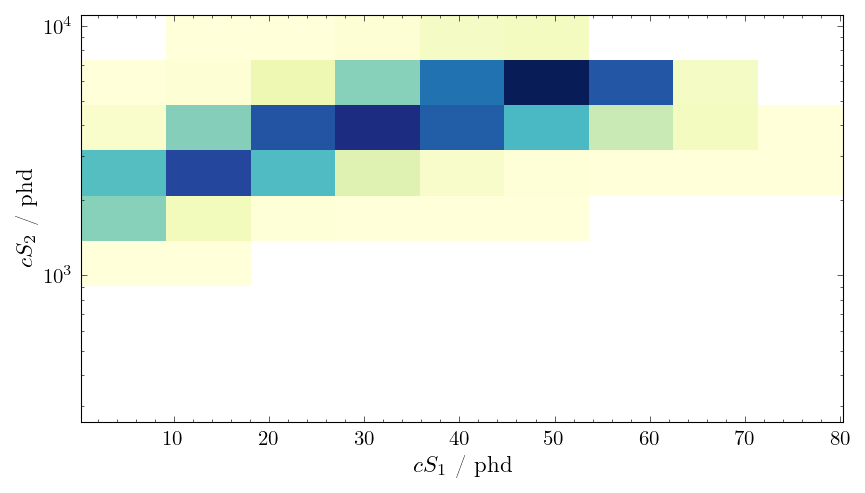

		plotting spectral PDF for 'nr_background'


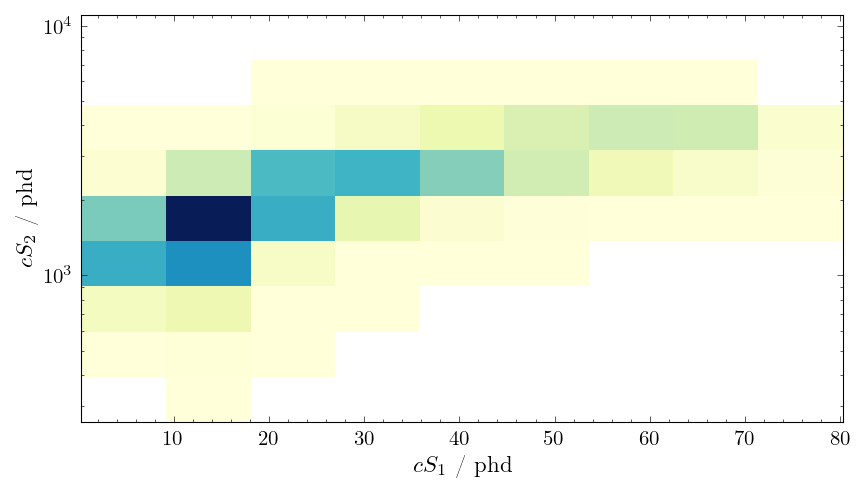

		finished within 0:00:30.655951 h'
	calculating the expected number of ER and NR background events within the binned observable space
		calculating the number of ER background events expected within the WIMP EROI
		calculating the number of NR background events expected within the WIMP EROI


/home/daniel/Desktop/arbeitsstuff/sfs/github_repo_v2/sfs.py:1543: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  expected_number_of_events_float_per_energy_bin = [exposure_t_y *integrate.quad(
/home/daniel/Desktop/arbeitsstuff/sfs/github_repo_v2/sfs.py:1543: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  expected_number_of_events_float_per_energy_bin = [exposure_t_y *integrate.quad(


		updating the 'spectrum_components_dict'
		finished within 19246 days, 16:22:58.408213 h'
cwpec: starting WIMP mass loop with k=0/4 for 10.00 GeV
	calculating the PDF of the WIMP spectrum within the binned observable space
		calculating 'integral_spectrum_dict' for the high-statistics WIMP spectrum
		generating the high-statistics WIMP signature by executing NEST
		calculating the PDF
		updating the 'spectrum_components_dict'
		deleting the high-statistics WIMP signature
		plotting spectral PDF for 'wimps'


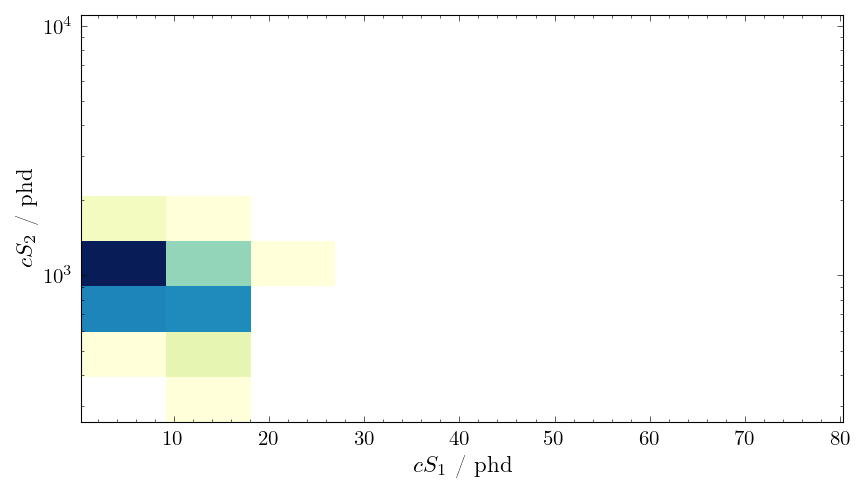

		finished within 0:00:35.410517 h'
	calculating the expected number of WIMP events within the binned observable space
		calculating the number of WIMP events expected within the WIMP EROI
		updating the 'spectrum_components_dict'
		finished within 19246 days, 16:23:01.933088 h'
	simulating 5 background-only datasets
		generating the 'spectrum_dict's
		generating the ER and NR background 'signature's
	calculating the maximum likelihood parameter estimators
		a priori calculations
		defining the 'log_likelihood_function'
[1.00000000e-06 1.13159567e-06 1.28050875e-06 1.44901815e-06
 1.63970266e-06 1.85548042e-06 2.09965360e-06 2.37595891e-06
 2.68862481e-06 3.04243618e-06 3.44280759e-06 3.89586614e-06
 4.40854524e-06 4.98869069e-06 5.64518076e-06 6.38806207e-06
 7.22870335e-06 8.17996938e-06 9.25641789e-06 1.04745224e-05
 1.18529241e-05 1.34127175e-05 1.51777730e-05 1.71751022e-05
 1.94352711e-05 2.19928686e-05 2.48870348e-05 2.81620607e-05
 3.18680658e-05 3.60617651e-05 4.08073370e-05 4

/home/daniel/Desktop/arbeitsstuff/sfs/github_repo_v2/sfs.py:3622: RuntimeWarning: overflow encountered in double_scalars
  lf_val = lf_val *(lambda_b**n_obs_b *np.exp(-lambda_b)) # neglecting the expression 'n_obs_b!' since those don't depend on the parameters but are extremely expensive to compute
/home/daniel/Desktop/arbeitsstuff/sfs/github_repo_v2/sfs.py:3622: RuntimeWarning: invalid value encountered in double_scalars
  lf_val = lf_val *(lambda_b**n_obs_b *np.exp(-lambda_b)) # neglecting the expression 'n_obs_b!' since those don't depend on the parameters but are extremely expensive to compute


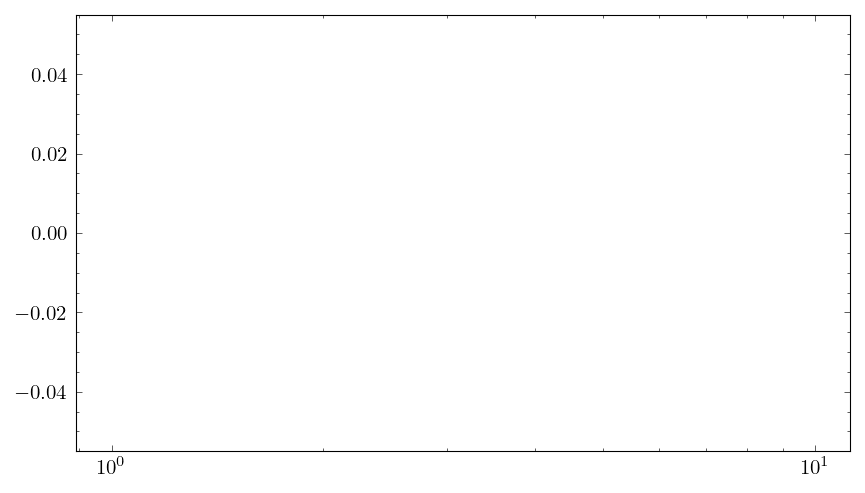

		minimizing -1*'log_likelihood_function'
		maximum likelihood estimators
		sigmas: [0.01]
		thetas: [[0.9, 0.91]]
		a priori calculations
		defining the 'log_likelihood_function'
[1.00000000e-06 1.13159567e-06 1.28050875e-06 1.44901815e-06
 1.63970266e-06 1.85548042e-06 2.09965360e-06 2.37595891e-06
 2.68862481e-06 3.04243618e-06 3.44280759e-06 3.89586614e-06
 4.40854524e-06 4.98869069e-06 5.64518076e-06 6.38806207e-06
 7.22870335e-06 8.17996938e-06 9.25641789e-06 1.04745224e-05
 1.18529241e-05 1.34127175e-05 1.51777730e-05 1.71751022e-05
 1.94352711e-05 2.19928686e-05 2.48870348e-05 2.81620607e-05
 3.18680658e-05 3.60617651e-05 4.08073370e-05 4.61774057e-05
 5.22541521e-05 5.91305720e-05 6.69118990e-05 7.57172149e-05
 8.56812721e-05 9.69565562e-05 1.09715619e-04 1.24153719e-04
 1.40491810e-04 1.58979923e-04 1.79900992e-04 2.03575182e-04
 2.30364794e-04 2.60679802e-04 2.94984134e-04 3.33802767e-04
 3.77729765e-04 4.27437364e-04 4.83686269e-04 5.47337285e-04
 6.19364499e-04 7.00870182e

/home/daniel/Desktop/arbeitsstuff/sfs/github_repo_v2/sfs.py:3622: RuntimeWarning: overflow encountered in double_scalars
  lf_val = lf_val *(lambda_b**n_obs_b *np.exp(-lambda_b)) # neglecting the expression 'n_obs_b!' since those don't depend on the parameters but are extremely expensive to compute
/usr/lib/python3/dist-packages/scipy/optimize/optimize.py:697: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]
/home/daniel/Desktop/arbeitsstuff/sfs/github_repo_v2/sfs.py:3622: RuntimeWarning: invalid value encountered in double_scalars
  lf_val = lf_val *(lambda_b**n_obs_b *np.exp(-lambda_b)) # neglecting the expression 'n_obs_b!' since those don't depend on the parameters but are extremely expensive to compute


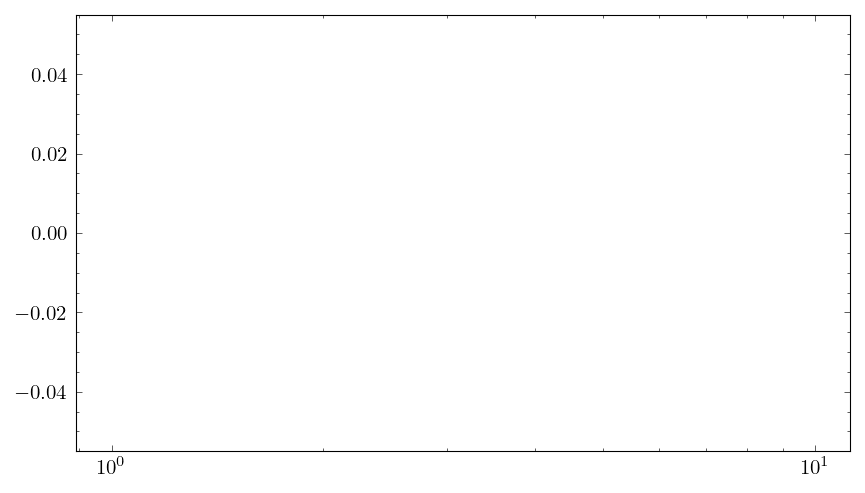

		minimizing -1*'log_likelihood_function'
		maximum likelihood estimators
		sigmas: [0.01, 0.01]
		thetas: [[0.9, 0.91], [0.9, 0.91]]
		a priori calculations
		defining the 'log_likelihood_function'
[1.00000000e-06 1.13159567e-06 1.28050875e-06 1.44901815e-06
 1.63970266e-06 1.85548042e-06 2.09965360e-06 2.37595891e-06
 2.68862481e-06 3.04243618e-06 3.44280759e-06 3.89586614e-06
 4.40854524e-06 4.98869069e-06 5.64518076e-06 6.38806207e-06
 7.22870335e-06 8.17996938e-06 9.25641789e-06 1.04745224e-05
 1.18529241e-05 1.34127175e-05 1.51777730e-05 1.71751022e-05
 1.94352711e-05 2.19928686e-05 2.48870348e-05 2.81620607e-05
 3.18680658e-05 3.60617651e-05 4.08073370e-05 4.61774057e-05
 5.22541521e-05 5.91305720e-05 6.69118990e-05 7.57172149e-05
 8.56812721e-05 9.69565562e-05 1.09715619e-04 1.24153719e-04
 1.40491810e-04 1.58979923e-04 1.79900992e-04 2.03575182e-04
 2.30364794e-04 2.60679802e-04 2.94984134e-04 3.33802767e-04
 3.77729765e-04 4.27437364e-04 4.83686269e-04 5.47337285e-04
 6.19364

/home/daniel/Desktop/arbeitsstuff/sfs/github_repo_v2/sfs.py:3622: RuntimeWarning: overflow encountered in double_scalars
  lf_val = lf_val *(lambda_b**n_obs_b *np.exp(-lambda_b)) # neglecting the expression 'n_obs_b!' since those don't depend on the parameters but are extremely expensive to compute
/usr/lib/python3/dist-packages/scipy/optimize/optimize.py:697: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]
/home/daniel/Desktop/arbeitsstuff/sfs/github_repo_v2/sfs.py:3622: RuntimeWarning: invalid value encountered in double_scalars
  lf_val = lf_val *(lambda_b**n_obs_b *np.exp(-lambda_b)) # neglecting the expression 'n_obs_b!' since those don't depend on the parameters but are extremely expensive to compute


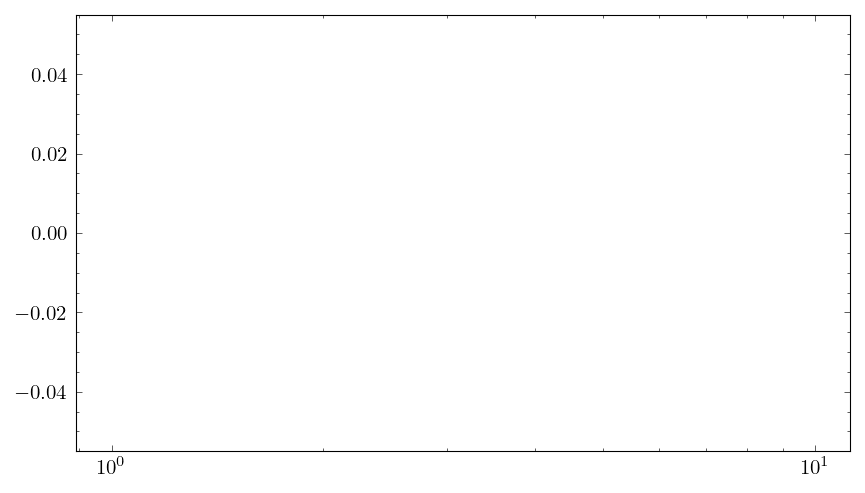

		minimizing -1*'log_likelihood_function'
		maximum likelihood estimators
		sigmas: [0.01, 0.01, 0.01]
		thetas: [[0.9, 0.91], [0.9, 0.91], [0.9, 0.91]]
		a priori calculations
		defining the 'log_likelihood_function'
[1.00000000e-06 1.13159567e-06 1.28050875e-06 1.44901815e-06
 1.63970266e-06 1.85548042e-06 2.09965360e-06 2.37595891e-06
 2.68862481e-06 3.04243618e-06 3.44280759e-06 3.89586614e-06
 4.40854524e-06 4.98869069e-06 5.64518076e-06 6.38806207e-06
 7.22870335e-06 8.17996938e-06 9.25641789e-06 1.04745224e-05
 1.18529241e-05 1.34127175e-05 1.51777730e-05 1.71751022e-05
 1.94352711e-05 2.19928686e-05 2.48870348e-05 2.81620607e-05
 3.18680658e-05 3.60617651e-05 4.08073370e-05 4.61774057e-05
 5.22541521e-05 5.91305720e-05 6.69118990e-05 7.57172149e-05
 8.56812721e-05 9.69565562e-05 1.09715619e-04 1.24153719e-04
 1.40491810e-04 1.58979923e-04 1.79900992e-04 2.03575182e-04
 2.30364794e-04 2.60679802e-04 2.94984134e-04 3.33802767e-04
 3.77729765e-04 4.27437364e-04 4.83686269e-04 5.47

/home/daniel/Desktop/arbeitsstuff/sfs/github_repo_v2/sfs.py:3622: RuntimeWarning: overflow encountered in double_scalars
  lf_val = lf_val *(lambda_b**n_obs_b *np.exp(-lambda_b)) # neglecting the expression 'n_obs_b!' since those don't depend on the parameters but are extremely expensive to compute
/usr/lib/python3/dist-packages/scipy/optimize/optimize.py:697: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]
/home/daniel/Desktop/arbeitsstuff/sfs/github_repo_v2/sfs.py:3622: RuntimeWarning: invalid value encountered in double_scalars
  lf_val = lf_val *(lambda_b**n_obs_b *np.exp(-lambda_b)) # neglecting the expression 'n_obs_b!' since those don't depend on the parameters but are extremely expensive to compute


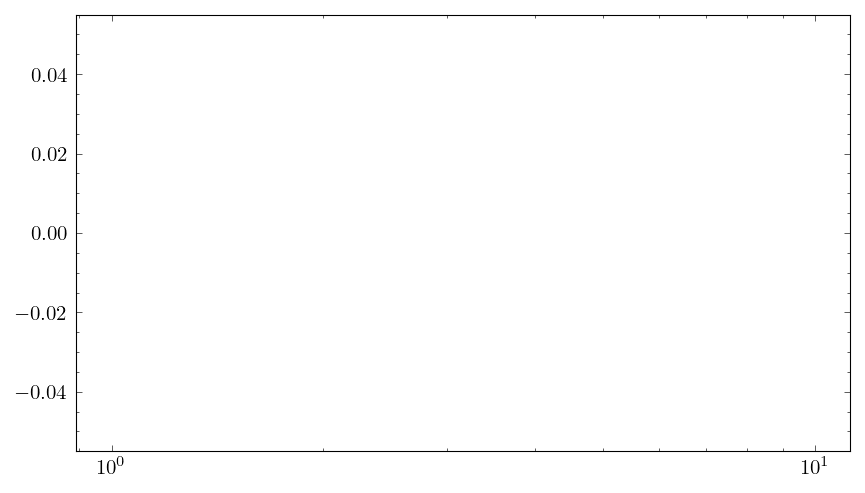

		minimizing -1*'log_likelihood_function'
		maximum likelihood estimators
		sigmas: [0.01, 0.01, 0.01, 0.01]
		thetas: [[0.9, 0.91], [0.9, 0.91], [0.9, 0.91], [0.9, 0.91]]
		a priori calculations
		defining the 'log_likelihood_function'
[1.00000000e-06 1.13159567e-06 1.28050875e-06 1.44901815e-06
 1.63970266e-06 1.85548042e-06 2.09965360e-06 2.37595891e-06
 2.68862481e-06 3.04243618e-06 3.44280759e-06 3.89586614e-06
 4.40854524e-06 4.98869069e-06 5.64518076e-06 6.38806207e-06
 7.22870335e-06 8.17996938e-06 9.25641789e-06 1.04745224e-05
 1.18529241e-05 1.34127175e-05 1.51777730e-05 1.71751022e-05
 1.94352711e-05 2.19928686e-05 2.48870348e-05 2.81620607e-05
 3.18680658e-05 3.60617651e-05 4.08073370e-05 4.61774057e-05
 5.22541521e-05 5.91305720e-05 6.69118990e-05 7.57172149e-05
 8.56812721e-05 9.69565562e-05 1.09715619e-04 1.24153719e-04
 1.40491810e-04 1.58979923e-04 1.79900992e-04 2.03575182e-04
 2.30364794e-04 2.60679802e-04 2.94984134e-04 3.33802767e-04
 3.77729765e-04 4.27437364e-04 

/home/daniel/Desktop/arbeitsstuff/sfs/github_repo_v2/sfs.py:3622: RuntimeWarning: overflow encountered in double_scalars
  lf_val = lf_val *(lambda_b**n_obs_b *np.exp(-lambda_b)) # neglecting the expression 'n_obs_b!' since those don't depend on the parameters but are extremely expensive to compute
/usr/lib/python3/dist-packages/scipy/optimize/optimize.py:697: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]
/home/daniel/Desktop/arbeitsstuff/sfs/github_repo_v2/sfs.py:3622: RuntimeWarning: invalid value encountered in double_scalars
  lf_val = lf_val *(lambda_b**n_obs_b *np.exp(-lambda_b)) # neglecting the expression 'n_obs_b!' since those don't depend on the parameters but are extremely expensive to compute


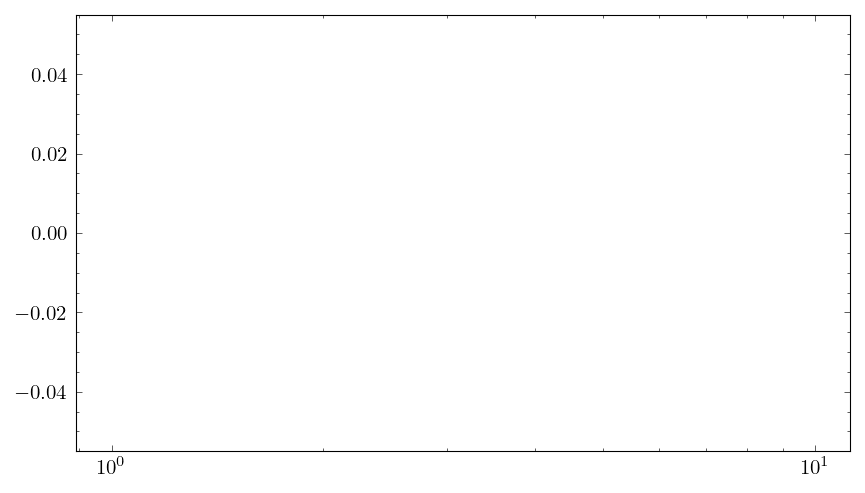

		minimizing -1*'log_likelihood_function'
		maximum likelihood estimators
		sigmas: [0.01, 0.01, 0.01, 0.01, 0.01]
		thetas: [[0.9, 0.91], [0.9, 0.91], [0.9, 0.91], [0.9, 0.91], [0.9, 0.91]]
cwpec: starting WIMP mass loop with k=1/4 for 36.84 GeV
	calculating the PDF of the WIMP spectrum within the binned observable space
		calculating 'integral_spectrum_dict' for the high-statistics WIMP spectrum


/home/daniel/Desktop/arbeitsstuff/sfs/github_repo_v2/sfs.py:3622: RuntimeWarning: overflow encountered in double_scalars
  lf_val = lf_val *(lambda_b**n_obs_b *np.exp(-lambda_b)) # neglecting the expression 'n_obs_b!' since those don't depend on the parameters but are extremely expensive to compute
/usr/lib/python3/dist-packages/scipy/optimize/optimize.py:697: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]


		generating the high-statistics WIMP signature by executing NEST
		calculating the PDF
		updating the 'spectrum_components_dict'
		deleting the high-statistics WIMP signature
		plotting spectral PDF for 'wimps'


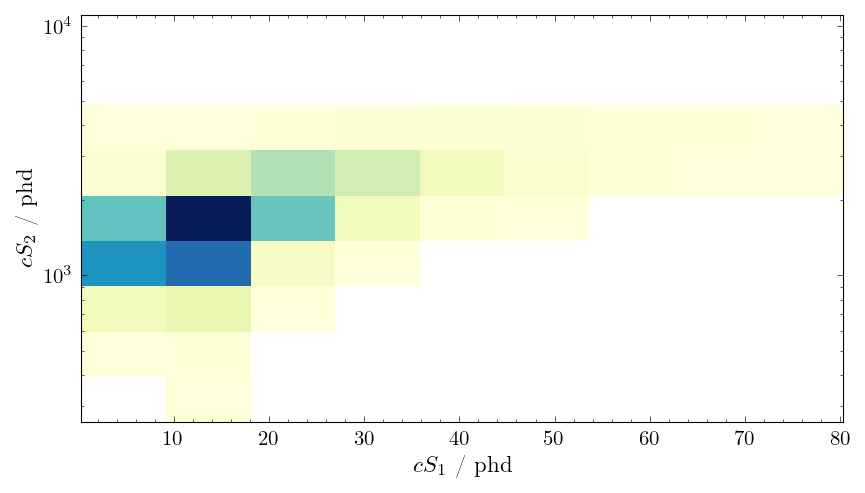

		finished within 0:01:02.757637 h'
	calculating the expected number of WIMP events within the binned observable space
		calculating the number of WIMP events expected within the WIMP EROI
		updating the 'spectrum_components_dict'
		finished within 19246 days, 16:23:40.834702 h'
	simulating 5 background-only datasets
		generating the 'spectrum_dict's


/home/daniel/Desktop/arbeitsstuff/sfs/github_repo_v2/sfs.py:1543: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  expected_number_of_events_float_per_energy_bin = [exposure_t_y *integrate.quad(
/home/daniel/Desktop/arbeitsstuff/sfs/github_repo_v2/sfs.py:1543: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  expected_number_of_events_float_per_energy_bin = [exposure_t_y *integrate.quad(


		generating the ER and NR background 'signature's
	calculating the maximum likelihood parameter estimators
		a priori calculations
		defining the 'log_likelihood_function'
[1.00000000e-06 1.13159567e-06 1.28050875e-06 1.44901815e-06
 1.63970266e-06 1.85548042e-06 2.09965360e-06 2.37595891e-06
 2.68862481e-06 3.04243618e-06 3.44280759e-06 3.89586614e-06
 4.40854524e-06 4.98869069e-06 5.64518076e-06 6.38806207e-06
 7.22870335e-06 8.17996938e-06 9.25641789e-06 1.04745224e-05
 1.18529241e-05 1.34127175e-05 1.51777730e-05 1.71751022e-05
 1.94352711e-05 2.19928686e-05 2.48870348e-05 2.81620607e-05
 3.18680658e-05 3.60617651e-05 4.08073370e-05 4.61774057e-05
 5.22541521e-05 5.91305720e-05 6.69118990e-05 7.57172149e-05
 8.56812721e-05 9.69565562e-05 1.09715619e-04 1.24153719e-04
 1.40491810e-04 1.58979923e-04 1.79900992e-04 2.03575182e-04
 2.30364794e-04 2.60679802e-04 2.94984134e-04 3.33802767e-04
 3.77729765e-04 4.27437364e-04 4.83686269e-04 5.47337285e-04
 6.19364499e-04 7.00870182e-04 7.9

/home/daniel/Desktop/arbeitsstuff/sfs/github_repo_v2/sfs.py:3622: RuntimeWarning: invalid value encountered in double_scalars
  lf_val = lf_val *(lambda_b**n_obs_b *np.exp(-lambda_b)) # neglecting the expression 'n_obs_b!' since those don't depend on the parameters but are extremely expensive to compute


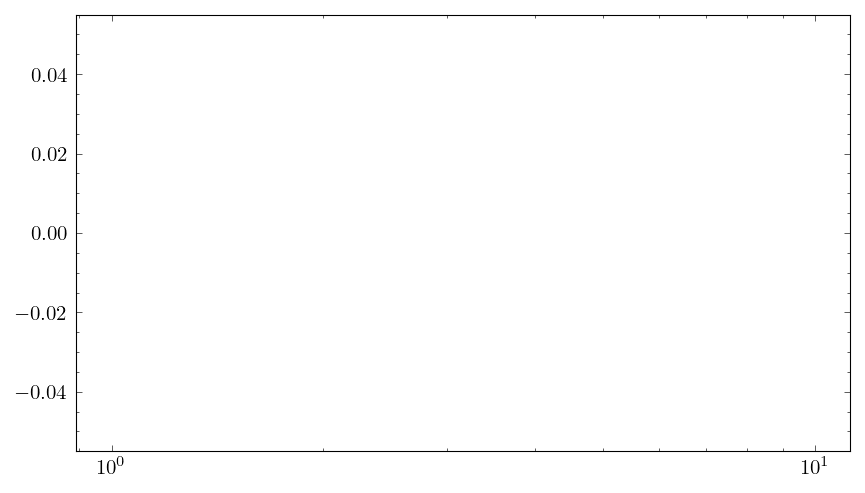

		minimizing -1*'log_likelihood_function'
		maximum likelihood estimators
		sigmas: [0.01]
		thetas: [[0.9, 0.91]]
		a priori calculations
		defining the 'log_likelihood_function'
[1.00000000e-06 1.13159567e-06 1.28050875e-06 1.44901815e-06
 1.63970266e-06 1.85548042e-06 2.09965360e-06 2.37595891e-06
 2.68862481e-06 3.04243618e-06 3.44280759e-06 3.89586614e-06
 4.40854524e-06 4.98869069e-06 5.64518076e-06 6.38806207e-06
 7.22870335e-06 8.17996938e-06 9.25641789e-06 1.04745224e-05
 1.18529241e-05 1.34127175e-05 1.51777730e-05 1.71751022e-05
 1.94352711e-05 2.19928686e-05 2.48870348e-05 2.81620607e-05
 3.18680658e-05 3.60617651e-05 4.08073370e-05 4.61774057e-05
 5.22541521e-05 5.91305720e-05 6.69118990e-05 7.57172149e-05
 8.56812721e-05 9.69565562e-05 1.09715619e-04 1.24153719e-04
 1.40491810e-04 1.58979923e-04 1.79900992e-04 2.03575182e-04
 2.30364794e-04 2.60679802e-04 2.94984134e-04 3.33802767e-04
 3.77729765e-04 4.27437364e-04 4.83686269e-04 5.47337285e-04
 6.19364499e-04 7.00870182e

/home/daniel/Desktop/arbeitsstuff/sfs/github_repo_v2/sfs.py:3622: RuntimeWarning: overflow encountered in double_scalars
  lf_val = lf_val *(lambda_b**n_obs_b *np.exp(-lambda_b)) # neglecting the expression 'n_obs_b!' since those don't depend on the parameters but are extremely expensive to compute
/usr/lib/python3/dist-packages/scipy/optimize/optimize.py:697: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]
/home/daniel/Desktop/arbeitsstuff/sfs/github_repo_v2/sfs.py:3622: RuntimeWarning: invalid value encountered in double_scalars
  lf_val = lf_val *(lambda_b**n_obs_b *np.exp(-lambda_b)) # neglecting the expression 'n_obs_b!' since those don't depend on the parameters but are extremely expensive to compute


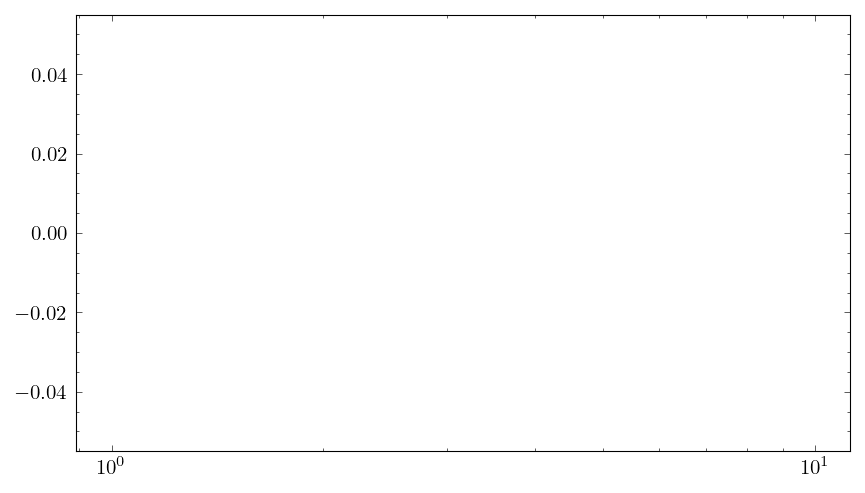

		minimizing -1*'log_likelihood_function'
		maximum likelihood estimators
		sigmas: [0.01, 0.01]
		thetas: [[0.9, 0.91], [0.9, 0.91]]
		a priori calculations
		defining the 'log_likelihood_function'
[1.00000000e-06 1.13159567e-06 1.28050875e-06 1.44901815e-06
 1.63970266e-06 1.85548042e-06 2.09965360e-06 2.37595891e-06
 2.68862481e-06 3.04243618e-06 3.44280759e-06 3.89586614e-06
 4.40854524e-06 4.98869069e-06 5.64518076e-06 6.38806207e-06
 7.22870335e-06 8.17996938e-06 9.25641789e-06 1.04745224e-05
 1.18529241e-05 1.34127175e-05 1.51777730e-05 1.71751022e-05
 1.94352711e-05 2.19928686e-05 2.48870348e-05 2.81620607e-05
 3.18680658e-05 3.60617651e-05 4.08073370e-05 4.61774057e-05
 5.22541521e-05 5.91305720e-05 6.69118990e-05 7.57172149e-05
 8.56812721e-05 9.69565562e-05 1.09715619e-04 1.24153719e-04
 1.40491810e-04 1.58979923e-04 1.79900992e-04 2.03575182e-04
 2.30364794e-04 2.60679802e-04 2.94984134e-04 3.33802767e-04
 3.77729765e-04 4.27437364e-04 4.83686269e-04 5.47337285e-04
 6.19364

/home/daniel/Desktop/arbeitsstuff/sfs/github_repo_v2/sfs.py:3622: RuntimeWarning: overflow encountered in double_scalars
  lf_val = lf_val *(lambda_b**n_obs_b *np.exp(-lambda_b)) # neglecting the expression 'n_obs_b!' since those don't depend on the parameters but are extremely expensive to compute
/usr/lib/python3/dist-packages/scipy/optimize/optimize.py:697: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]
/home/daniel/Desktop/arbeitsstuff/sfs/github_repo_v2/sfs.py:3622: RuntimeWarning: invalid value encountered in double_scalars
  lf_val = lf_val *(lambda_b**n_obs_b *np.exp(-lambda_b)) # neglecting the expression 'n_obs_b!' since those don't depend on the parameters but are extremely expensive to compute


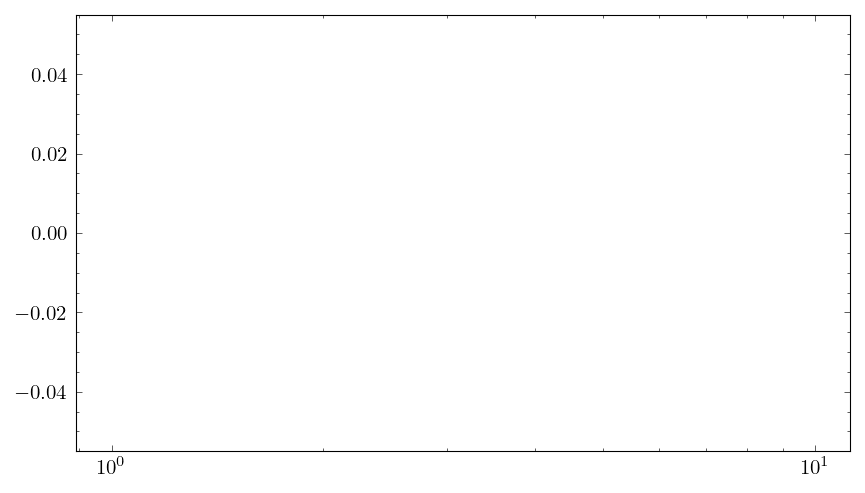

		minimizing -1*'log_likelihood_function'
		maximum likelihood estimators
		sigmas: [0.01, 0.01, 0.01]
		thetas: [[0.9, 0.91], [0.9, 0.91], [0.9, 0.91]]
		a priori calculations
		defining the 'log_likelihood_function'
[1.00000000e-06 1.13159567e-06 1.28050875e-06 1.44901815e-06
 1.63970266e-06 1.85548042e-06 2.09965360e-06 2.37595891e-06
 2.68862481e-06 3.04243618e-06 3.44280759e-06 3.89586614e-06
 4.40854524e-06 4.98869069e-06 5.64518076e-06 6.38806207e-06
 7.22870335e-06 8.17996938e-06 9.25641789e-06 1.04745224e-05
 1.18529241e-05 1.34127175e-05 1.51777730e-05 1.71751022e-05
 1.94352711e-05 2.19928686e-05 2.48870348e-05 2.81620607e-05
 3.18680658e-05 3.60617651e-05 4.08073370e-05 4.61774057e-05
 5.22541521e-05 5.91305720e-05 6.69118990e-05 7.57172149e-05
 8.56812721e-05 9.69565562e-05 1.09715619e-04 1.24153719e-04
 1.40491810e-04 1.58979923e-04 1.79900992e-04 2.03575182e-04
 2.30364794e-04 2.60679802e-04 2.94984134e-04 3.33802767e-04
 3.77729765e-04 4.27437364e-04 4.83686269e-04 5.47

/home/daniel/Desktop/arbeitsstuff/sfs/github_repo_v2/sfs.py:3622: RuntimeWarning: overflow encountered in double_scalars
  lf_val = lf_val *(lambda_b**n_obs_b *np.exp(-lambda_b)) # neglecting the expression 'n_obs_b!' since those don't depend on the parameters but are extremely expensive to compute
/usr/lib/python3/dist-packages/scipy/optimize/optimize.py:697: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]
/home/daniel/Desktop/arbeitsstuff/sfs/github_repo_v2/sfs.py:3622: RuntimeWarning: invalid value encountered in double_scalars
  lf_val = lf_val *(lambda_b**n_obs_b *np.exp(-lambda_b)) # neglecting the expression 'n_obs_b!' since those don't depend on the parameters but are extremely expensive to compute


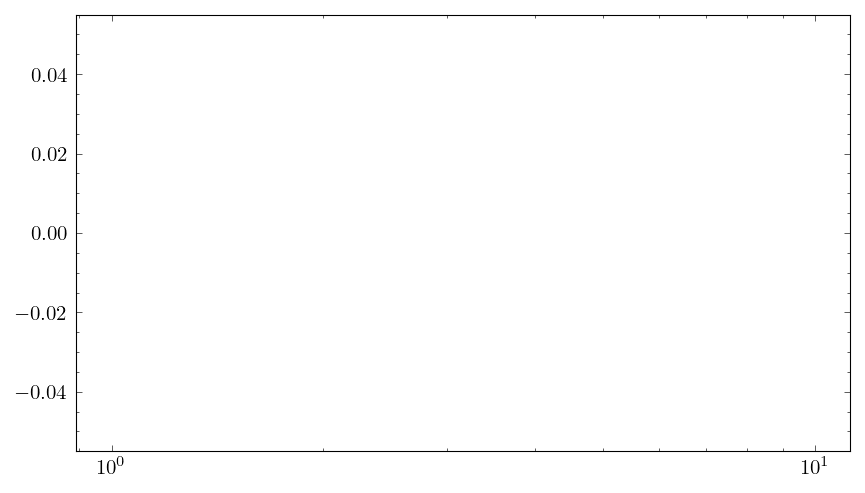

		minimizing -1*'log_likelihood_function'
		maximum likelihood estimators
		sigmas: [0.01, 0.01, 0.01, 0.01]
		thetas: [[0.9, 0.91], [0.9, 0.91], [0.9, 0.91], [0.9, 0.91]]
		a priori calculations
		defining the 'log_likelihood_function'
[1.00000000e-06 1.13159567e-06 1.28050875e-06 1.44901815e-06
 1.63970266e-06 1.85548042e-06 2.09965360e-06 2.37595891e-06
 2.68862481e-06 3.04243618e-06 3.44280759e-06 3.89586614e-06
 4.40854524e-06 4.98869069e-06 5.64518076e-06 6.38806207e-06
 7.22870335e-06 8.17996938e-06 9.25641789e-06 1.04745224e-05
 1.18529241e-05 1.34127175e-05 1.51777730e-05 1.71751022e-05
 1.94352711e-05 2.19928686e-05 2.48870348e-05 2.81620607e-05
 3.18680658e-05 3.60617651e-05 4.08073370e-05 4.61774057e-05
 5.22541521e-05 5.91305720e-05 6.69118990e-05 7.57172149e-05
 8.56812721e-05 9.69565562e-05 1.09715619e-04 1.24153719e-04
 1.40491810e-04 1.58979923e-04 1.79900992e-04 2.03575182e-04
 2.30364794e-04 2.60679802e-04 2.94984134e-04 3.33802767e-04
 3.77729765e-04 4.27437364e-04 

/home/daniel/Desktop/arbeitsstuff/sfs/github_repo_v2/sfs.py:3622: RuntimeWarning: overflow encountered in double_scalars
  lf_val = lf_val *(lambda_b**n_obs_b *np.exp(-lambda_b)) # neglecting the expression 'n_obs_b!' since those don't depend on the parameters but are extremely expensive to compute
/usr/lib/python3/dist-packages/scipy/optimize/optimize.py:697: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]
/home/daniel/Desktop/arbeitsstuff/sfs/github_repo_v2/sfs.py:3622: RuntimeWarning: invalid value encountered in double_scalars
  lf_val = lf_val *(lambda_b**n_obs_b *np.exp(-lambda_b)) # neglecting the expression 'n_obs_b!' since those don't depend on the parameters but are extremely expensive to compute


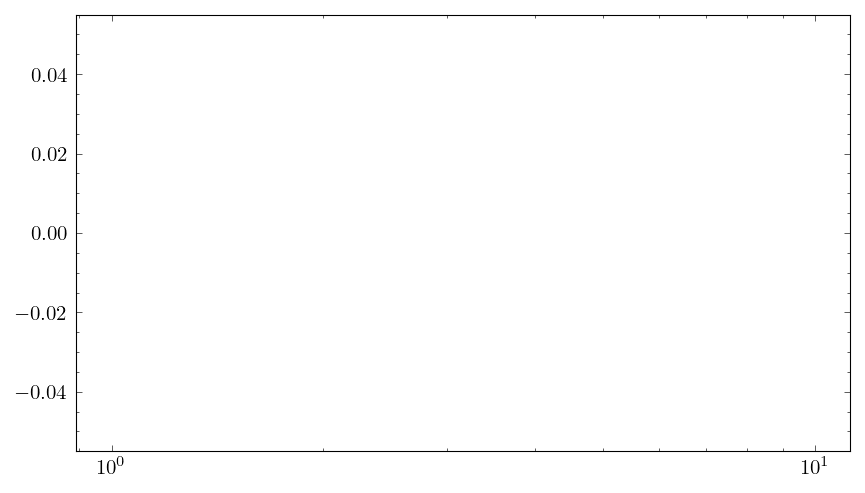

		minimizing -1*'log_likelihood_function'
		maximum likelihood estimators
		sigmas: [0.01, 0.01, 0.01, 0.01, 0.01]
		thetas: [[0.9, 0.91], [0.9, 0.91], [0.9, 0.91], [0.9, 0.91], [0.9, 0.91]]
cwpec: starting WIMP mass loop with k=2/4 for 135.72 GeV
	calculating the PDF of the WIMP spectrum within the binned observable space
		calculating 'integral_spectrum_dict' for the high-statistics WIMP spectrum


/home/daniel/Desktop/arbeitsstuff/sfs/github_repo_v2/sfs.py:3622: RuntimeWarning: overflow encountered in double_scalars
  lf_val = lf_val *(lambda_b**n_obs_b *np.exp(-lambda_b)) # neglecting the expression 'n_obs_b!' since those don't depend on the parameters but are extremely expensive to compute
/usr/lib/python3/dist-packages/scipy/optimize/optimize.py:697: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]


		generating the high-statistics WIMP signature by executing NEST
		calculating the PDF
		updating the 'spectrum_components_dict'
		deleting the high-statistics WIMP signature
		plotting spectral PDF for 'wimps'


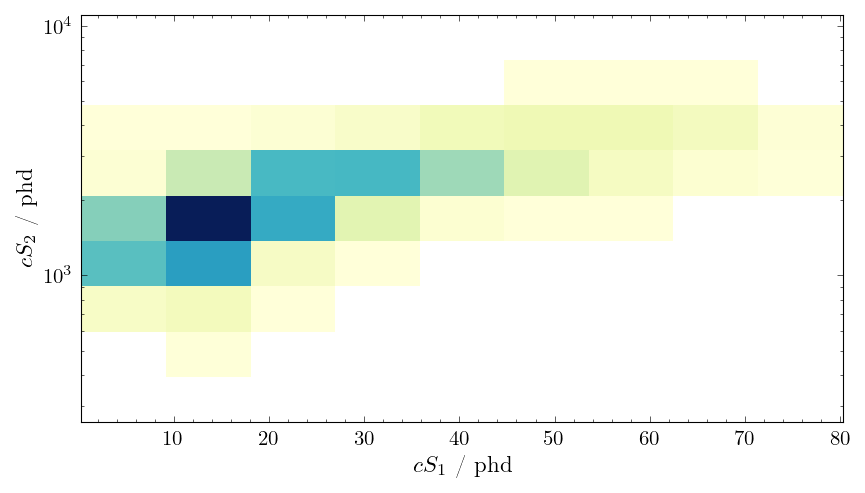

		finished within 0:01:29.380052 h'
	calculating the expected number of WIMP events within the binned observable space
		calculating the number of WIMP events expected within the WIMP EROI
		updating the 'spectrum_components_dict'
		finished within 19246 days, 16:24:11.686991 h'
	simulating 5 background-only datasets
		generating the 'spectrum_dict's


/home/daniel/Desktop/arbeitsstuff/sfs/github_repo_v2/sfs.py:1543: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  expected_number_of_events_float_per_energy_bin = [exposure_t_y *integrate.quad(
/home/daniel/Desktop/arbeitsstuff/sfs/github_repo_v2/sfs.py:1543: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  expected_number_of_events_float_per_energy_bin = [exposure_t_y *integrate.quad(


		generating the ER and NR background 'signature's
	calculating the maximum likelihood parameter estimators
		a priori calculations
		defining the 'log_likelihood_function'
[1.00000000e-06 1.13159567e-06 1.28050875e-06 1.44901815e-06
 1.63970266e-06 1.85548042e-06 2.09965360e-06 2.37595891e-06
 2.68862481e-06 3.04243618e-06 3.44280759e-06 3.89586614e-06
 4.40854524e-06 4.98869069e-06 5.64518076e-06 6.38806207e-06
 7.22870335e-06 8.17996938e-06 9.25641789e-06 1.04745224e-05
 1.18529241e-05 1.34127175e-05 1.51777730e-05 1.71751022e-05
 1.94352711e-05 2.19928686e-05 2.48870348e-05 2.81620607e-05
 3.18680658e-05 3.60617651e-05 4.08073370e-05 4.61774057e-05
 5.22541521e-05 5.91305720e-05 6.69118990e-05 7.57172149e-05
 8.56812721e-05 9.69565562e-05 1.09715619e-04 1.24153719e-04
 1.40491810e-04 1.58979923e-04 1.79900992e-04 2.03575182e-04
 2.30364794e-04 2.60679802e-04 2.94984134e-04 3.33802767e-04
 3.77729765e-04 4.27437364e-04 4.83686269e-04 5.47337285e-04
 6.19364499e-04 7.00870182e-04 7.9

/home/daniel/Desktop/arbeitsstuff/sfs/github_repo_v2/sfs.py:3622: RuntimeWarning: invalid value encountered in double_scalars
  lf_val = lf_val *(lambda_b**n_obs_b *np.exp(-lambda_b)) # neglecting the expression 'n_obs_b!' since those don't depend on the parameters but are extremely expensive to compute


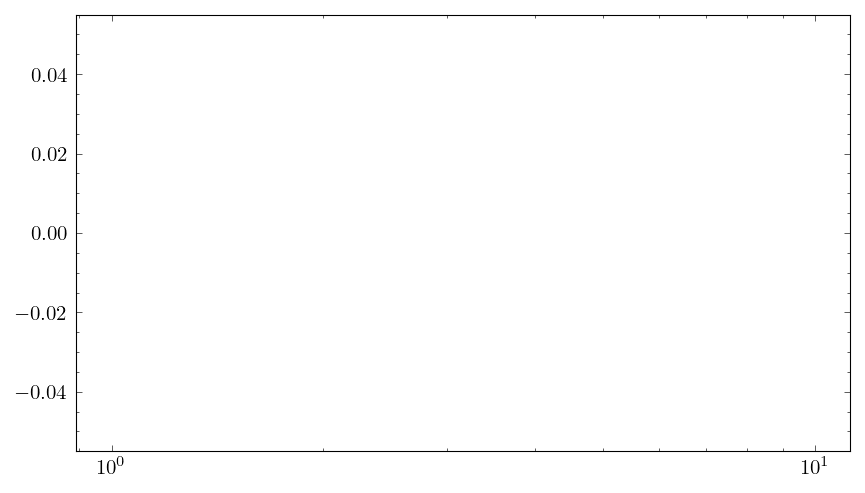

		minimizing -1*'log_likelihood_function'
		maximum likelihood estimators
		sigmas: [0.01]
		thetas: [[0.9, 0.91]]
		a priori calculations
		defining the 'log_likelihood_function'
[1.00000000e-06 1.13159567e-06 1.28050875e-06 1.44901815e-06
 1.63970266e-06 1.85548042e-06 2.09965360e-06 2.37595891e-06
 2.68862481e-06 3.04243618e-06 3.44280759e-06 3.89586614e-06
 4.40854524e-06 4.98869069e-06 5.64518076e-06 6.38806207e-06
 7.22870335e-06 8.17996938e-06 9.25641789e-06 1.04745224e-05
 1.18529241e-05 1.34127175e-05 1.51777730e-05 1.71751022e-05
 1.94352711e-05 2.19928686e-05 2.48870348e-05 2.81620607e-05
 3.18680658e-05 3.60617651e-05 4.08073370e-05 4.61774057e-05
 5.22541521e-05 5.91305720e-05 6.69118990e-05 7.57172149e-05
 8.56812721e-05 9.69565562e-05 1.09715619e-04 1.24153719e-04
 1.40491810e-04 1.58979923e-04 1.79900992e-04 2.03575182e-04
 2.30364794e-04 2.60679802e-04 2.94984134e-04 3.33802767e-04
 3.77729765e-04 4.27437364e-04 4.83686269e-04 5.47337285e-04
 6.19364499e-04 7.00870182e

/home/daniel/Desktop/arbeitsstuff/sfs/github_repo_v2/sfs.py:3622: RuntimeWarning: overflow encountered in double_scalars
  lf_val = lf_val *(lambda_b**n_obs_b *np.exp(-lambda_b)) # neglecting the expression 'n_obs_b!' since those don't depend on the parameters but are extremely expensive to compute
/usr/lib/python3/dist-packages/scipy/optimize/optimize.py:697: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]
/home/daniel/Desktop/arbeitsstuff/sfs/github_repo_v2/sfs.py:3622: RuntimeWarning: invalid value encountered in double_scalars
  lf_val = lf_val *(lambda_b**n_obs_b *np.exp(-lambda_b)) # neglecting the expression 'n_obs_b!' since those don't depend on the parameters but are extremely expensive to compute


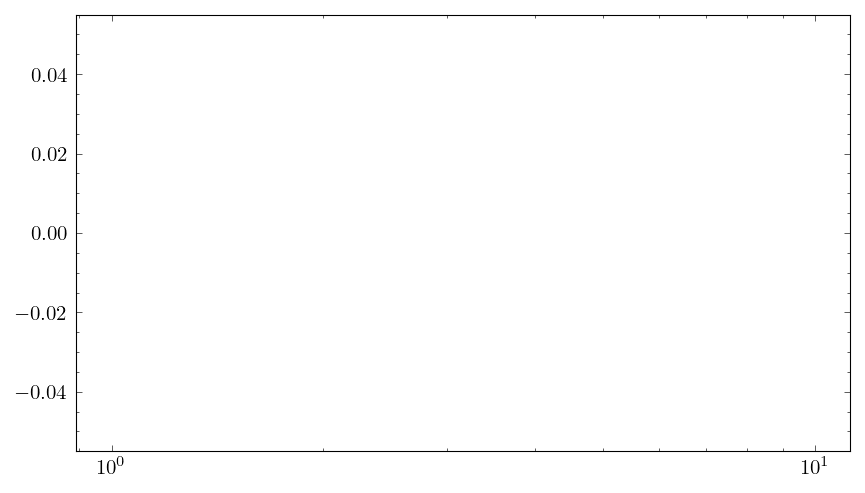

		minimizing -1*'log_likelihood_function'
		maximum likelihood estimators
		sigmas: [0.01, 0.01]
		thetas: [[0.9, 0.91], [0.9, 0.91]]
		a priori calculations
		defining the 'log_likelihood_function'
[1.00000000e-06 1.13159567e-06 1.28050875e-06 1.44901815e-06
 1.63970266e-06 1.85548042e-06 2.09965360e-06 2.37595891e-06
 2.68862481e-06 3.04243618e-06 3.44280759e-06 3.89586614e-06
 4.40854524e-06 4.98869069e-06 5.64518076e-06 6.38806207e-06
 7.22870335e-06 8.17996938e-06 9.25641789e-06 1.04745224e-05
 1.18529241e-05 1.34127175e-05 1.51777730e-05 1.71751022e-05
 1.94352711e-05 2.19928686e-05 2.48870348e-05 2.81620607e-05
 3.18680658e-05 3.60617651e-05 4.08073370e-05 4.61774057e-05
 5.22541521e-05 5.91305720e-05 6.69118990e-05 7.57172149e-05
 8.56812721e-05 9.69565562e-05 1.09715619e-04 1.24153719e-04
 1.40491810e-04 1.58979923e-04 1.79900992e-04 2.03575182e-04
 2.30364794e-04 2.60679802e-04 2.94984134e-04 3.33802767e-04
 3.77729765e-04 4.27437364e-04 4.83686269e-04 5.47337285e-04
 6.19364

/home/daniel/Desktop/arbeitsstuff/sfs/github_repo_v2/sfs.py:3622: RuntimeWarning: overflow encountered in double_scalars
  lf_val = lf_val *(lambda_b**n_obs_b *np.exp(-lambda_b)) # neglecting the expression 'n_obs_b!' since those don't depend on the parameters but are extremely expensive to compute
/usr/lib/python3/dist-packages/scipy/optimize/optimize.py:697: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]
/home/daniel/Desktop/arbeitsstuff/sfs/github_repo_v2/sfs.py:3622: RuntimeWarning: invalid value encountered in double_scalars
  lf_val = lf_val *(lambda_b**n_obs_b *np.exp(-lambda_b)) # neglecting the expression 'n_obs_b!' since those don't depend on the parameters but are extremely expensive to compute


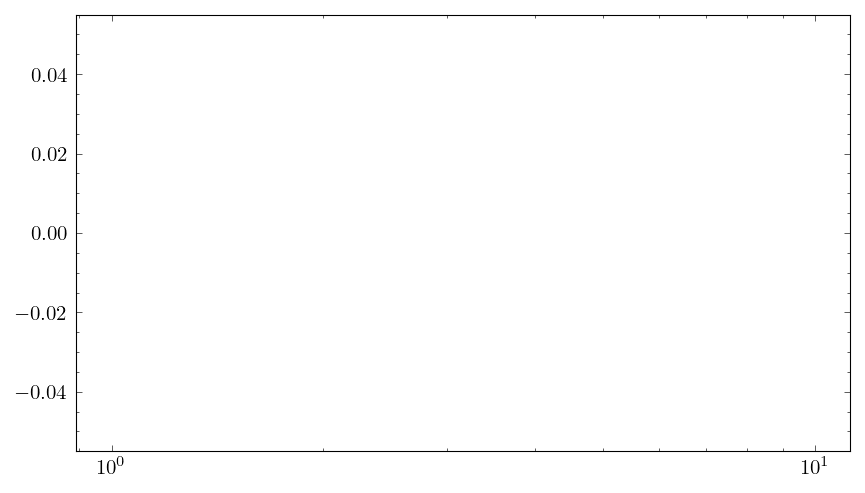

		minimizing -1*'log_likelihood_function'
		maximum likelihood estimators
		sigmas: [0.01, 0.01, 0.01]
		thetas: [[0.9, 0.91], [0.9, 0.91], [0.9, 0.91]]
		a priori calculations
		defining the 'log_likelihood_function'
[1.00000000e-06 1.13159567e-06 1.28050875e-06 1.44901815e-06
 1.63970266e-06 1.85548042e-06 2.09965360e-06 2.37595891e-06
 2.68862481e-06 3.04243618e-06 3.44280759e-06 3.89586614e-06
 4.40854524e-06 4.98869069e-06 5.64518076e-06 6.38806207e-06
 7.22870335e-06 8.17996938e-06 9.25641789e-06 1.04745224e-05
 1.18529241e-05 1.34127175e-05 1.51777730e-05 1.71751022e-05
 1.94352711e-05 2.19928686e-05 2.48870348e-05 2.81620607e-05
 3.18680658e-05 3.60617651e-05 4.08073370e-05 4.61774057e-05
 5.22541521e-05 5.91305720e-05 6.69118990e-05 7.57172149e-05
 8.56812721e-05 9.69565562e-05 1.09715619e-04 1.24153719e-04
 1.40491810e-04 1.58979923e-04 1.79900992e-04 2.03575182e-04
 2.30364794e-04 2.60679802e-04 2.94984134e-04 3.33802767e-04
 3.77729765e-04 4.27437364e-04 4.83686269e-04 5.47

/home/daniel/Desktop/arbeitsstuff/sfs/github_repo_v2/sfs.py:3622: RuntimeWarning: overflow encountered in double_scalars
  lf_val = lf_val *(lambda_b**n_obs_b *np.exp(-lambda_b)) # neglecting the expression 'n_obs_b!' since those don't depend on the parameters but are extremely expensive to compute
/usr/lib/python3/dist-packages/scipy/optimize/optimize.py:697: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]
/home/daniel/Desktop/arbeitsstuff/sfs/github_repo_v2/sfs.py:3622: RuntimeWarning: invalid value encountered in double_scalars
  lf_val = lf_val *(lambda_b**n_obs_b *np.exp(-lambda_b)) # neglecting the expression 'n_obs_b!' since those don't depend on the parameters but are extremely expensive to compute


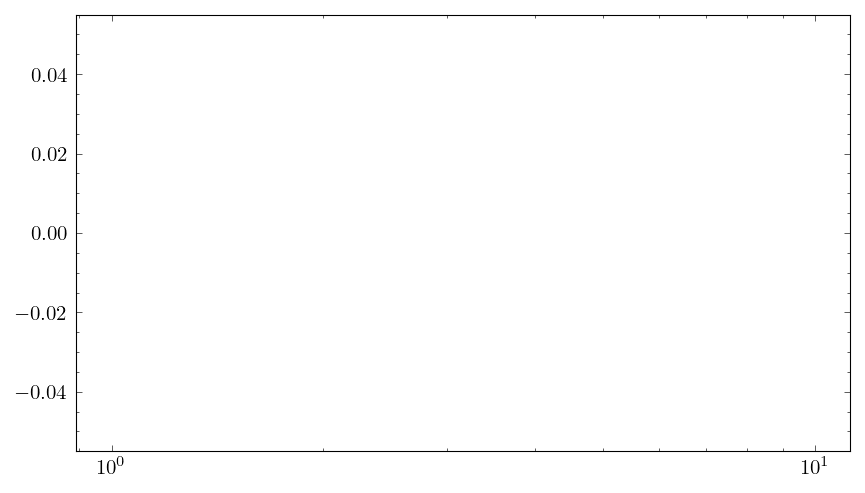

		minimizing -1*'log_likelihood_function'
		maximum likelihood estimators
		sigmas: [0.01, 0.01, 0.01, 0.01]
		thetas: [[0.9, 0.91], [0.9, 0.91], [0.9, 0.91], [0.9, 0.91]]
		a priori calculations
		defining the 'log_likelihood_function'
[1.00000000e-06 1.13159567e-06 1.28050875e-06 1.44901815e-06
 1.63970266e-06 1.85548042e-06 2.09965360e-06 2.37595891e-06
 2.68862481e-06 3.04243618e-06 3.44280759e-06 3.89586614e-06
 4.40854524e-06 4.98869069e-06 5.64518076e-06 6.38806207e-06
 7.22870335e-06 8.17996938e-06 9.25641789e-06 1.04745224e-05
 1.18529241e-05 1.34127175e-05 1.51777730e-05 1.71751022e-05
 1.94352711e-05 2.19928686e-05 2.48870348e-05 2.81620607e-05
 3.18680658e-05 3.60617651e-05 4.08073370e-05 4.61774057e-05
 5.22541521e-05 5.91305720e-05 6.69118990e-05 7.57172149e-05
 8.56812721e-05 9.69565562e-05 1.09715619e-04 1.24153719e-04
 1.40491810e-04 1.58979923e-04 1.79900992e-04 2.03575182e-04
 2.30364794e-04 2.60679802e-04 2.94984134e-04 3.33802767e-04
 3.77729765e-04 4.27437364e-04 

/home/daniel/Desktop/arbeitsstuff/sfs/github_repo_v2/sfs.py:3622: RuntimeWarning: overflow encountered in double_scalars
  lf_val = lf_val *(lambda_b**n_obs_b *np.exp(-lambda_b)) # neglecting the expression 'n_obs_b!' since those don't depend on the parameters but are extremely expensive to compute
/usr/lib/python3/dist-packages/scipy/optimize/optimize.py:697: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]
/home/daniel/Desktop/arbeitsstuff/sfs/github_repo_v2/sfs.py:3622: RuntimeWarning: invalid value encountered in double_scalars
  lf_val = lf_val *(lambda_b**n_obs_b *np.exp(-lambda_b)) # neglecting the expression 'n_obs_b!' since those don't depend on the parameters but are extremely expensive to compute


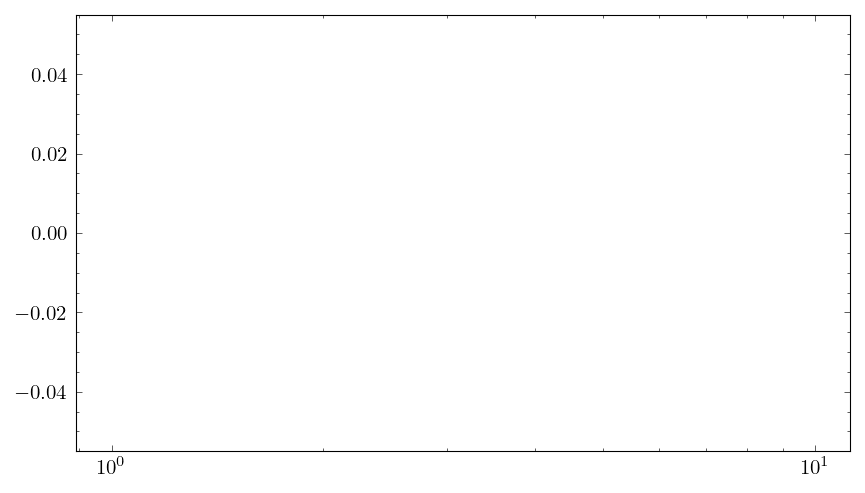

		minimizing -1*'log_likelihood_function'
		maximum likelihood estimators
		sigmas: [0.01, 0.01, 0.01, 0.01, 0.01]
		thetas: [[0.9, 0.91], [0.9, 0.91], [0.9, 0.91], [0.9, 0.91], [0.9, 0.91]]
cwpec: starting WIMP mass loop with k=3/4 for 500.00 GeV
	calculating the PDF of the WIMP spectrum within the binned observable space
		calculating 'integral_spectrum_dict' for the high-statistics WIMP spectrum


/home/daniel/Desktop/arbeitsstuff/sfs/github_repo_v2/sfs.py:3622: RuntimeWarning: overflow encountered in double_scalars
  lf_val = lf_val *(lambda_b**n_obs_b *np.exp(-lambda_b)) # neglecting the expression 'n_obs_b!' since those don't depend on the parameters but are extremely expensive to compute
/usr/lib/python3/dist-packages/scipy/optimize/optimize.py:697: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]


		generating the high-statistics WIMP signature by executing NEST
		calculating the PDF
		updating the 'spectrum_components_dict'
		deleting the high-statistics WIMP signature
		plotting spectral PDF for 'wimps'


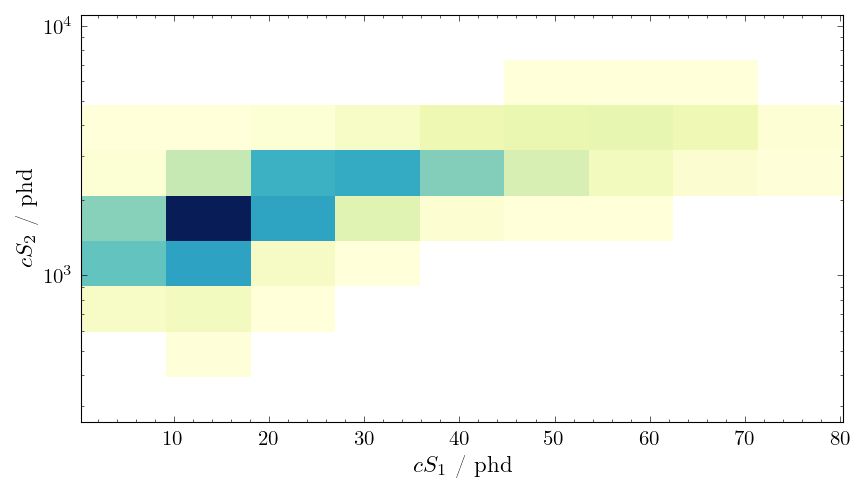

		finished within 0:01:56.364819 h'
	calculating the expected number of WIMP events within the binned observable space
		calculating the number of WIMP events expected within the WIMP EROI
		updating the 'spectrum_components_dict'
		finished within 19246 days, 16:24:32.773864 h'
	simulating 5 background-only datasets
		generating the 'spectrum_dict's


/home/daniel/Desktop/arbeitsstuff/sfs/github_repo_v2/sfs.py:1543: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  expected_number_of_events_float_per_energy_bin = [exposure_t_y *integrate.quad(
/home/daniel/Desktop/arbeitsstuff/sfs/github_repo_v2/sfs.py:1543: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  expected_number_of_events_float_per_energy_bin = [exposure_t_y *integrate.quad(


		generating the ER and NR background 'signature's
	calculating the maximum likelihood parameter estimators
		a priori calculations
		defining the 'log_likelihood_function'
[1.00000000e-06 1.13159567e-06 1.28050875e-06 1.44901815e-06
 1.63970266e-06 1.85548042e-06 2.09965360e-06 2.37595891e-06
 2.68862481e-06 3.04243618e-06 3.44280759e-06 3.89586614e-06
 4.40854524e-06 4.98869069e-06 5.64518076e-06 6.38806207e-06
 7.22870335e-06 8.17996938e-06 9.25641789e-06 1.04745224e-05
 1.18529241e-05 1.34127175e-05 1.51777730e-05 1.71751022e-05
 1.94352711e-05 2.19928686e-05 2.48870348e-05 2.81620607e-05
 3.18680658e-05 3.60617651e-05 4.08073370e-05 4.61774057e-05
 5.22541521e-05 5.91305720e-05 6.69118990e-05 7.57172149e-05
 8.56812721e-05 9.69565562e-05 1.09715619e-04 1.24153719e-04
 1.40491810e-04 1.58979923e-04 1.79900992e-04 2.03575182e-04
 2.30364794e-04 2.60679802e-04 2.94984134e-04 3.33802767e-04
 3.77729765e-04 4.27437364e-04 4.83686269e-04 5.47337285e-04
 6.19364499e-04 7.00870182e-04 7.9

/home/daniel/Desktop/arbeitsstuff/sfs/github_repo_v2/sfs.py:3622: RuntimeWarning: invalid value encountered in double_scalars
  lf_val = lf_val *(lambda_b**n_obs_b *np.exp(-lambda_b)) # neglecting the expression 'n_obs_b!' since those don't depend on the parameters but are extremely expensive to compute


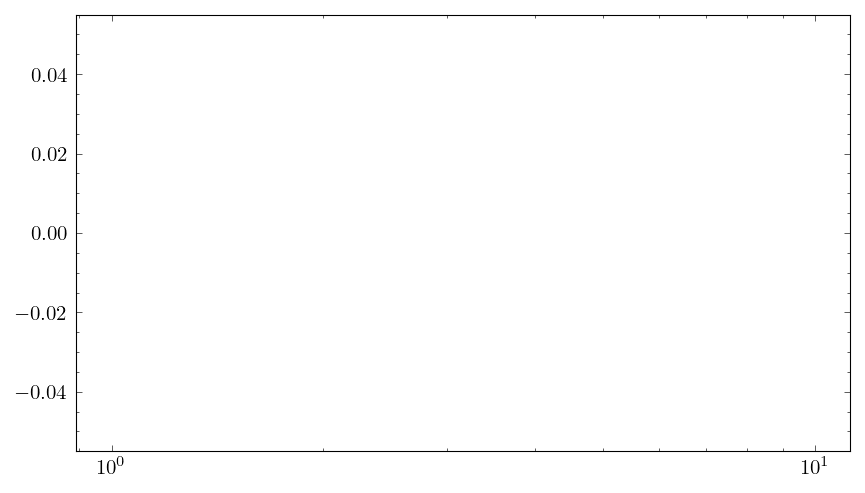

		minimizing -1*'log_likelihood_function'
		maximum likelihood estimators
		sigmas: [0.01]
		thetas: [[0.9, 0.91]]
		a priori calculations
		defining the 'log_likelihood_function'
[1.00000000e-06 1.13159567e-06 1.28050875e-06 1.44901815e-06
 1.63970266e-06 1.85548042e-06 2.09965360e-06 2.37595891e-06
 2.68862481e-06 3.04243618e-06 3.44280759e-06 3.89586614e-06
 4.40854524e-06 4.98869069e-06 5.64518076e-06 6.38806207e-06
 7.22870335e-06 8.17996938e-06 9.25641789e-06 1.04745224e-05
 1.18529241e-05 1.34127175e-05 1.51777730e-05 1.71751022e-05
 1.94352711e-05 2.19928686e-05 2.48870348e-05 2.81620607e-05
 3.18680658e-05 3.60617651e-05 4.08073370e-05 4.61774057e-05
 5.22541521e-05 5.91305720e-05 6.69118990e-05 7.57172149e-05
 8.56812721e-05 9.69565562e-05 1.09715619e-04 1.24153719e-04
 1.40491810e-04 1.58979923e-04 1.79900992e-04 2.03575182e-04
 2.30364794e-04 2.60679802e-04 2.94984134e-04 3.33802767e-04
 3.77729765e-04 4.27437364e-04 4.83686269e-04 5.47337285e-04
 6.19364499e-04 7.00870182e

/home/daniel/Desktop/arbeitsstuff/sfs/github_repo_v2/sfs.py:3622: RuntimeWarning: overflow encountered in double_scalars
  lf_val = lf_val *(lambda_b**n_obs_b *np.exp(-lambda_b)) # neglecting the expression 'n_obs_b!' since those don't depend on the parameters but are extremely expensive to compute
/usr/lib/python3/dist-packages/scipy/optimize/optimize.py:697: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]
/home/daniel/Desktop/arbeitsstuff/sfs/github_repo_v2/sfs.py:3622: RuntimeWarning: invalid value encountered in double_scalars
  lf_val = lf_val *(lambda_b**n_obs_b *np.exp(-lambda_b)) # neglecting the expression 'n_obs_b!' since those don't depend on the parameters but are extremely expensive to compute


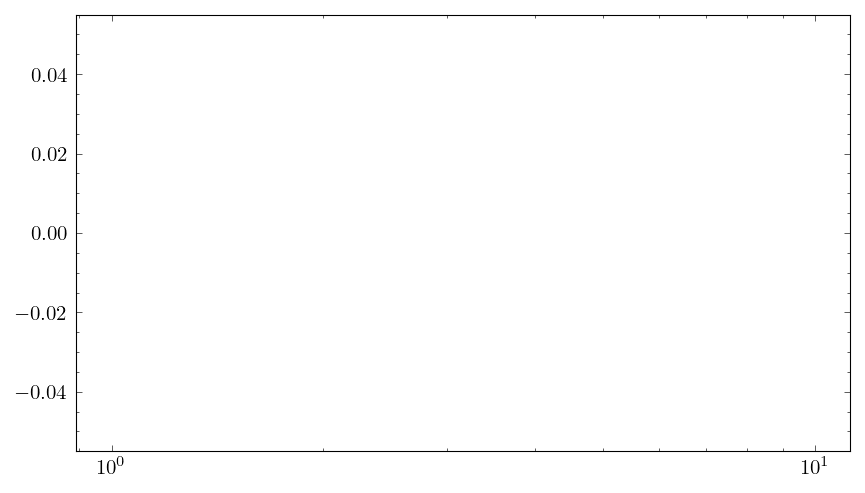

		minimizing -1*'log_likelihood_function'
		maximum likelihood estimators
		sigmas: [0.01, 0.01]
		thetas: [[0.9, 0.91], [0.9, 0.91]]
		a priori calculations
		defining the 'log_likelihood_function'
[1.00000000e-06 1.13159567e-06 1.28050875e-06 1.44901815e-06
 1.63970266e-06 1.85548042e-06 2.09965360e-06 2.37595891e-06
 2.68862481e-06 3.04243618e-06 3.44280759e-06 3.89586614e-06
 4.40854524e-06 4.98869069e-06 5.64518076e-06 6.38806207e-06
 7.22870335e-06 8.17996938e-06 9.25641789e-06 1.04745224e-05
 1.18529241e-05 1.34127175e-05 1.51777730e-05 1.71751022e-05
 1.94352711e-05 2.19928686e-05 2.48870348e-05 2.81620607e-05
 3.18680658e-05 3.60617651e-05 4.08073370e-05 4.61774057e-05
 5.22541521e-05 5.91305720e-05 6.69118990e-05 7.57172149e-05
 8.56812721e-05 9.69565562e-05 1.09715619e-04 1.24153719e-04
 1.40491810e-04 1.58979923e-04 1.79900992e-04 2.03575182e-04
 2.30364794e-04 2.60679802e-04 2.94984134e-04 3.33802767e-04
 3.77729765e-04 4.27437364e-04 4.83686269e-04 5.47337285e-04
 6.19364

/home/daniel/Desktop/arbeitsstuff/sfs/github_repo_v2/sfs.py:3622: RuntimeWarning: overflow encountered in double_scalars
  lf_val = lf_val *(lambda_b**n_obs_b *np.exp(-lambda_b)) # neglecting the expression 'n_obs_b!' since those don't depend on the parameters but are extremely expensive to compute
/usr/lib/python3/dist-packages/scipy/optimize/optimize.py:697: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]
/home/daniel/Desktop/arbeitsstuff/sfs/github_repo_v2/sfs.py:3622: RuntimeWarning: invalid value encountered in double_scalars
  lf_val = lf_val *(lambda_b**n_obs_b *np.exp(-lambda_b)) # neglecting the expression 'n_obs_b!' since those don't depend on the parameters but are extremely expensive to compute


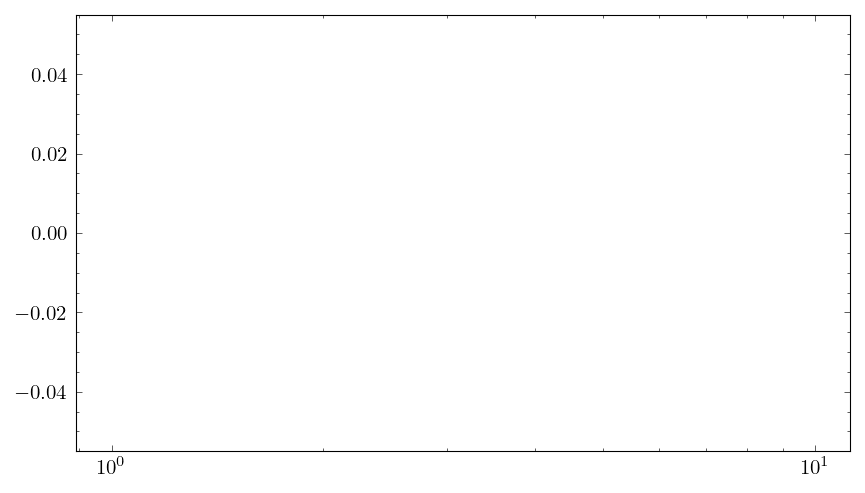

		minimizing -1*'log_likelihood_function'
		maximum likelihood estimators
		sigmas: [0.01, 0.01, 0.01]
		thetas: [[0.9, 0.91], [0.9, 0.91], [0.9, 0.91]]
		a priori calculations
		defining the 'log_likelihood_function'
[1.00000000e-06 1.13159567e-06 1.28050875e-06 1.44901815e-06
 1.63970266e-06 1.85548042e-06 2.09965360e-06 2.37595891e-06
 2.68862481e-06 3.04243618e-06 3.44280759e-06 3.89586614e-06
 4.40854524e-06 4.98869069e-06 5.64518076e-06 6.38806207e-06
 7.22870335e-06 8.17996938e-06 9.25641789e-06 1.04745224e-05
 1.18529241e-05 1.34127175e-05 1.51777730e-05 1.71751022e-05
 1.94352711e-05 2.19928686e-05 2.48870348e-05 2.81620607e-05
 3.18680658e-05 3.60617651e-05 4.08073370e-05 4.61774057e-05
 5.22541521e-05 5.91305720e-05 6.69118990e-05 7.57172149e-05
 8.56812721e-05 9.69565562e-05 1.09715619e-04 1.24153719e-04
 1.40491810e-04 1.58979923e-04 1.79900992e-04 2.03575182e-04
 2.30364794e-04 2.60679802e-04 2.94984134e-04 3.33802767e-04
 3.77729765e-04 4.27437364e-04 4.83686269e-04 5.47

/home/daniel/Desktop/arbeitsstuff/sfs/github_repo_v2/sfs.py:3622: RuntimeWarning: overflow encountered in double_scalars
  lf_val = lf_val *(lambda_b**n_obs_b *np.exp(-lambda_b)) # neglecting the expression 'n_obs_b!' since those don't depend on the parameters but are extremely expensive to compute
/usr/lib/python3/dist-packages/scipy/optimize/optimize.py:697: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]
/home/daniel/Desktop/arbeitsstuff/sfs/github_repo_v2/sfs.py:3622: RuntimeWarning: invalid value encountered in double_scalars
  lf_val = lf_val *(lambda_b**n_obs_b *np.exp(-lambda_b)) # neglecting the expression 'n_obs_b!' since those don't depend on the parameters but are extremely expensive to compute


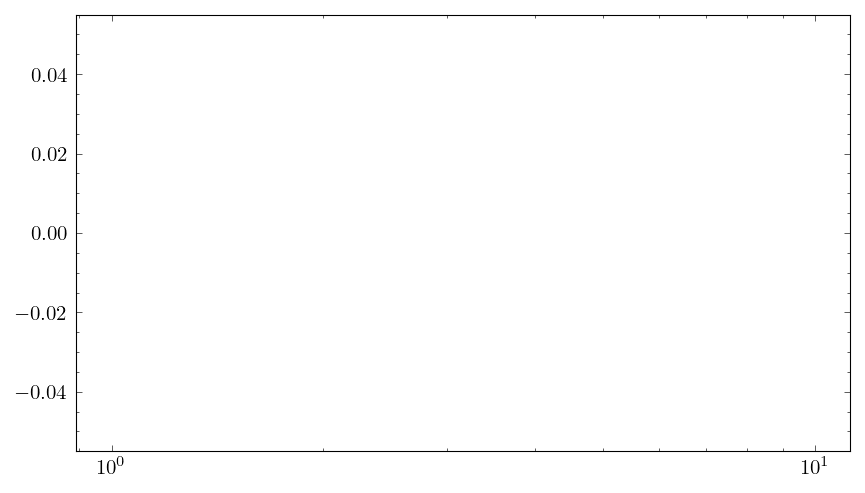

		minimizing -1*'log_likelihood_function'
		maximum likelihood estimators
		sigmas: [0.01, 0.01, 0.01, 0.01]
		thetas: [[0.9, 0.91], [0.9, 0.91], [0.9, 0.91], [0.9, 0.91]]
		a priori calculations
		defining the 'log_likelihood_function'
[1.00000000e-06 1.13159567e-06 1.28050875e-06 1.44901815e-06
 1.63970266e-06 1.85548042e-06 2.09965360e-06 2.37595891e-06
 2.68862481e-06 3.04243618e-06 3.44280759e-06 3.89586614e-06
 4.40854524e-06 4.98869069e-06 5.64518076e-06 6.38806207e-06
 7.22870335e-06 8.17996938e-06 9.25641789e-06 1.04745224e-05
 1.18529241e-05 1.34127175e-05 1.51777730e-05 1.71751022e-05
 1.94352711e-05 2.19928686e-05 2.48870348e-05 2.81620607e-05
 3.18680658e-05 3.60617651e-05 4.08073370e-05 4.61774057e-05
 5.22541521e-05 5.91305720e-05 6.69118990e-05 7.57172149e-05
 8.56812721e-05 9.69565562e-05 1.09715619e-04 1.24153719e-04
 1.40491810e-04 1.58979923e-04 1.79900992e-04 2.03575182e-04
 2.30364794e-04 2.60679802e-04 2.94984134e-04 3.33802767e-04
 3.77729765e-04 4.27437364e-04 

/home/daniel/Desktop/arbeitsstuff/sfs/github_repo_v2/sfs.py:3622: RuntimeWarning: overflow encountered in double_scalars
  lf_val = lf_val *(lambda_b**n_obs_b *np.exp(-lambda_b)) # neglecting the expression 'n_obs_b!' since those don't depend on the parameters but are extremely expensive to compute
/usr/lib/python3/dist-packages/scipy/optimize/optimize.py:697: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]
/home/daniel/Desktop/arbeitsstuff/sfs/github_repo_v2/sfs.py:3622: RuntimeWarning: invalid value encountered in double_scalars
  lf_val = lf_val *(lambda_b**n_obs_b *np.exp(-lambda_b)) # neglecting the expression 'n_obs_b!' since those don't depend on the parameters but are extremely expensive to compute


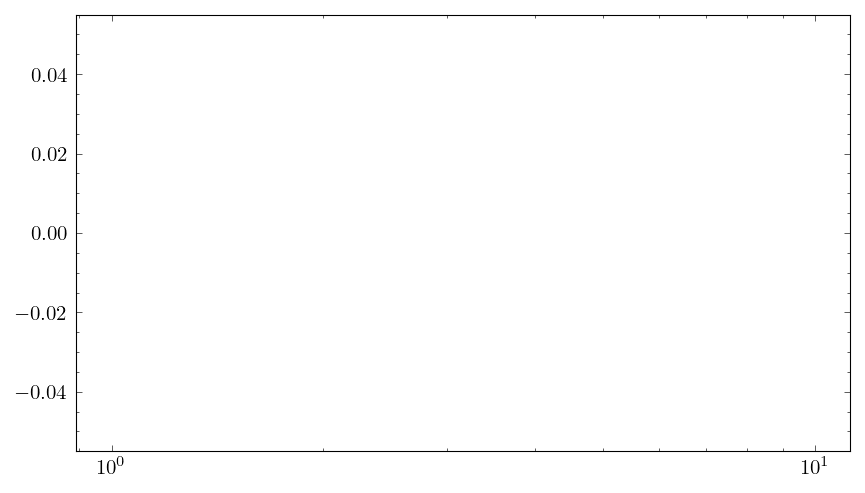

		minimizing -1*'log_likelihood_function'
		maximum likelihood estimators
		sigmas: [0.01, 0.01, 0.01, 0.01, 0.01]
		thetas: [[0.9, 0.91], [0.9, 0.91], [0.9, 0.91], [0.9, 0.91], [0.9, 0.91]]
cwpec: filling the output dictionary
cwpec: finished within 0:04:31.094522 h


test output:

'cs1_bin_edges': [0.295612, 9.180485666666666, 18.06535933333333, 26.950232999999997, 35.83510666666666, 44.719980333333325, 53.604853999999996, 62.48972766666666, 71.37460133333333, 80.259475]

'cs2_bin_edges': [11114.42, 7316.478068591842, 4816.342312795947, 3170.5354757515483, 2087.122249656629, 1373.9254199573907, 904.4372268637585, 595.3792581859177, 391.9304187723472, 258.002695]

er_background
'spectral_pdf': [[0.0, 1.745661392782329e-05, 0.00027249348570260743, 0.0019977178670572407, 0.007169984842549858, 0.008294446242144524, 0.0, 0.0, 0.0], [6.343988964013829e-05, 0.0020492361666978897, 0.012851899790520633, 0.03875496023298193, 0.07510133351499566, 0.1073160243200436, 0.08278948175145188, 0.00752

/home/daniel/Desktop/arbeitsstuff/sfs/github_repo_v2/sfs.py:3622: RuntimeWarning: overflow encountered in double_scalars
  lf_val = lf_val *(lambda_b**n_obs_b *np.exp(-lambda_b)) # neglecting the expression 'n_obs_b!' since those don't depend on the parameters but are extremely expensive to compute
/usr/lib/python3/dist-packages/scipy/optimize/optimize.py:697: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]


In [13]:


if [False,True][1]:


    wimp_parameter_exclusion_curve_dict = sfs.calculate_wimp_parameter_exclusion_curve(
        # physical detector parameters
        detector__drift_field_v_cm                                       = darwin_baseline_detector_drift_field_v_cm,
        detector__nest_parameter_dict                                    = darwin_baseline_detector_dict,
        detector__runtime_y                                              = darwin_baseline_detector_runtime_y,
        detector__fiducial_mass_t                                        = darwin_baseline_detector_fiducial_mass_t,
        detector__detector_name                                          = "darwin_baseline_detector_sensitest",
        # physical spectrum parameters
        spectrum__default_spectrum_profiles                              = sfs.spectrum_dict_default_dict,
        spectrum__resources                                              = abspath_resources,
        spectrum__er_background_model                                    = "combined_er_background",
        spectrum__nr_background_model                                    = "combined_nr_background",
        spectrum__wimp_model                                             = "nr_wimps_wimprates",
        # simulation setting
        simulation__er_spectrum_energy_simulation_window_kev             = default_recoil_energy_simulation_window_er,
        simulation__nr_spectrum_energy_simulation_window_kev             = default_recoil_energy_simulation_window_nr,
        simulation__number_of_spectrum_energy_bins                       = default_simulation_energy_bins,
        simulation__number_of_upper_limit_simulations_per_wimp_mass      = 5, # 500
        simulation__number_of_pdf_calculation_events                     = 40000, # 4000000
        simulation__number_of_samples_for_expectation_value_computation  = 10, # 100
        # limit calculation parameters
        limit__er_eroi_kev                                               = default_wimp_eroi_kev_ee,
        limit__nr_eroi_kev                                               = default_wimp_eroi_kev_nr,
        limit__wimp_mass_gev_list                                        = list(np.geomspace(start=10, stop=500, num=4, endpoint=True)),
        limit__number_of_cs1_bins                                        = 10, #40,
        limit__number_of_cs2_bins                                        = 10, #40,
        # flags
        flag_verbose                                                     = [False, True, "high-level-only"][2],
        flag_plot_pdfs                                                   = [False, True, "er_nr_only"][1],
        flag_load_er_and_nr_signatures_for_pdf_calculation               = [False,True][1],
    )
    
    
    # printing test output
    print(f"\n\ntest output:")
    print(f"\n'cs1_bin_edges': {wimp_parameter_exclusion_curve_dict['spectrum_components']['cs1_bin_edges']}")
    print(f"\n'cs2_bin_edges': {wimp_parameter_exclusion_curve_dict['spectrum_components']['cs2_bin_edges']}")
    for spectrum_string in ["er_background", "nr_background", "wimps"]:
        print(f"\n{spectrum_string}")
        print(f"'spectral_pdf': {wimp_parameter_exclusion_curve_dict['spectrum_components'][spectrum_string]['spectral_pdf']}")
        print(f"'number_of_expected_events_within_eroi': {wimp_parameter_exclusion_curve_dict['spectrum_components'][spectrum_string]['number_of_expected_events_within_eroi']}")



In [17]:
3000**3000

2310809578111909272693109431184832846484968454396283812529115413319435556973292122101720139716262409469889717513948376726158501486182636383531313869623735751595188198743086350673413093292498741784795660389148326466211372843337723144590341000538769498117226562808444716579845071408688720747381120135479199680471885180482121554984483377022066232113498842614313541610752653690490275184816645775562870080222550532658199952189433551842563700110684899935346509404097452154895288699360903786484615575470777362920177718027703180305669825349020152868844727956235156059960772077214312800556301983539901820176796454299860300131486822074451633519214994291242241850066416567586776526981799888092096865174444248800546127994730384671200620078154936387315118122040519117349396356198197315367766646921156257797160661163192060277301722871797101013527586327674333920080776435765228230385762165404932957246335621254520607306174400378047735376342518713628466946614321497738427647167939078993913147690702992638955965837451

In [14]:

from scipy.optimize import minimize


def testfunc(x,y,z):
    val = 0
    for i in range(5):
        addval = y*1.2
        val += addval
    val += -np.log(x)
    val += np.float64(4.3)*z
    return -1*val


#print(testfunc([1,1],[1,2],[1,1]))
print(testfunc(1,2,2))

minimum = minimize(
    fun = lambda x : testfunc(x[0],x[1],x[2]),
    x0   = [0,1,1],
    bounds = [[0,5000000], [0,5000000], [0,50000000]],
    method = None,
)


print(minimum.x)
#print(testfunc(minimum.x))
#print(testfunc([0,0,0]))





-20.6
[0. 1. 1.]


/tmp/ipykernel_332543/4269127390.py:9: RuntimeWarning: divide by zero encountered in log
  val += -np.log(x)
